### Step 0: Get packages and helper functions

In [1]:
# Add source and data file paths
import os
path = os.path.abspath(os.getcwd())
os.chdir("../..")
parent_path = os.path.abspath(os.getcwd())

import sys
sys.path.insert(1, parent_path + '\\source')
sys.path.insert(2, parent_path + '\\data')

import numpy as np; import torch; import time

# Import source/helper functions
from misc_helper import combine_layers, get_dt, get_userPar, training_loop, make_gif
from plot_helper import reference_plot, sample_plot
from trainingData_helper import generate_trainData
from windowSweep_helper import window_sweep_class
from pde_helper import PDE_class
from neuralNetwork_helper import Net, activation_func_a, weight_class, dtPINN

## Step 1: Define PDE problem and visualize 

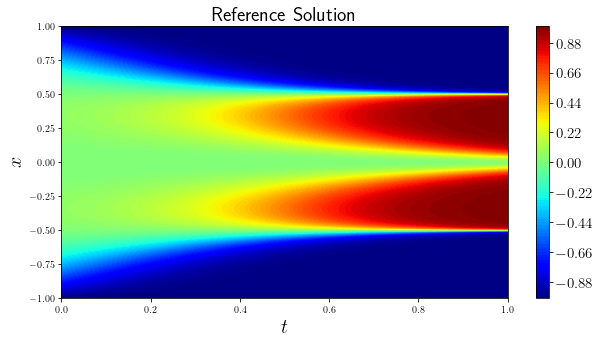

In [2]:
pde_type = 'allen-cahn'
newParams = {}

#pde_type = 'new'
#newParams = {}; newParams['data'] = parent_path+'\\data\\convec_10.mat'; newParams['pde'] = 'u_t + 10*u_x'; newParams['IC'] = 'np.sin(x)';

PDE = PDE_class(pde_type, newParams)
dataPar = PDE.data()

# Reference solution
reference_plot(dataPar)

## Step 2: dtPINN user settings

In [3]:
# Neural network parameters
input_encoding = 1 # Boolean for encode input to enforce exact boundary condtions
M = 10; L = get_dt(dataPar['xmin'], dataPar['xmax'], 1) # Hyperparameters for exact BC encoding, not used if turned off
hidden_layers = [50, 50, 50, 50]; layers = combine_layers(input_encoding, M, hidden_layers) # PINN layers
# Note Adam and L-BFGS epoch/iterations are per frame for generating animations, the total amount is multiplied by the training loops defined below
# Will be cutoff early if a new network is added since optimizer needs to be reset via this control loop
adam_params = [500, 0.001] # Optimization Hyperparameters for Adam [epochs, learning rate]
lbfgs_params = [0.1, 500, None, -1, -1, 50] # Optimization Hyperparameters for LBFGS [learning rate, max iterations, max evaluations, tolerance gradient, tolerance change, history size]
adaptive_activation = 0 # Adaptive activation functions in NN
dirichlet_bc = 0 # Use Dirichlet boundary condtions based on reference solution (0 = no, 1 = yes), number of points will depend on reference solution not user-defined N_b
learned_weights = 0 
lambda_w = 100 # Weight applied to non PDE-reisudal loss terms

### Training data parameters
N_x = 100; N_t = 100; N_f = N_x*N_t # Number of collocation points in the ENTIRE domian (pre subdomain partitioning)
N_0 = 200 # Number of initial condtion points in the ENTIRE domain
N_b = 200 # Number of boundary condtion points in the ENTIRE domain
N_i = N_0 # Number of interface continuity points for each interface (total = N_i*(n-1))
collocation_sampling = 'grid' # Latin-hypercube or grid sampling
#collocation_sampling = 'lhs'

### From Algorithm 1 in paper
## 1. Choose stacked-decomposition parameters [n, dS, adaptive dt]
num_partitions = 1; dt = get_dt(dataPar['tmin'], dataPar['tmax'], num_partitions) # Number of time-slabs in domain (1 = PINN) and dt derived from number and t-domain; 
dS = 1 # Number of continuously training segments
causal_dS = 1 # Boolean for adding in intial dS segments causality or not (0 = no, 1 = yes)
stacked_tol = 0

## 2. Choose interface conditions [residual continuity, Cp continuity, other]
interface_condition = ['u'] # List of interface condtions to add (u = solution continuity, uavg = average solution continuity, residual = minimize residuals, rc = minimize residual continuity)
# [xPINN = 'uavg' + 'rc', C^p continuity = 'u' for first-order systems]

## 3. Choose transfer learning parameters [number of layers, trainability of layers]
# If all layers that are transfered and kept learnable = 'fine-tuning'
# If some layers that are transfered and made unlearnable = 'transfer learning'
layer_transfer = [1, 1, 1, 1, 1] # Boolean mask to transfer weights and bias (length = len(layers) - 1)
layer_trainability = [1, 1, 1, 1, 1] # Boolean mask to make layers continue to be learnable or not (length = len(layers) - 1)

## 4. Choose window-sweeping parameters [weighting scheme, scheme hyperparameters]
window_scheme = 'causal'
scheme_parameters = [10, 1, 0, 0]
#window_scheme = 'erf'
#scheme_parameters = [100, 1*10**(-7), 0.125*10**(-1), 1, 10**(-4), 1, 1]
# If 'none': , If 'uniform' or 'linear': width, propogate loss tolerance, dt, scale, use bc-set, use null-set; 
# If 'erf': sharpness, propogate loss tolerance, dt, scale, set cutoff tolerance, use bc-set, use null-set; 
# If 'causal': epsilon), bound tolerance

userPar = get_userPar(path, pde_type, input_encoding, M, L, layers, adam_params, lbfgs_params, adaptive_activation, learned_weights, N_x, N_t, N_f, N_0, N_b, N_i, collocation_sampling,\
                     num_partitions, dt, dS, causal_dS, interface_condition, layer_transfer, layer_trainability, window_scheme, scheme_parameters, PDE, stacked_tol, lambda_w, dirichlet_bc)

### Step 2.1: Generate and visualize training data

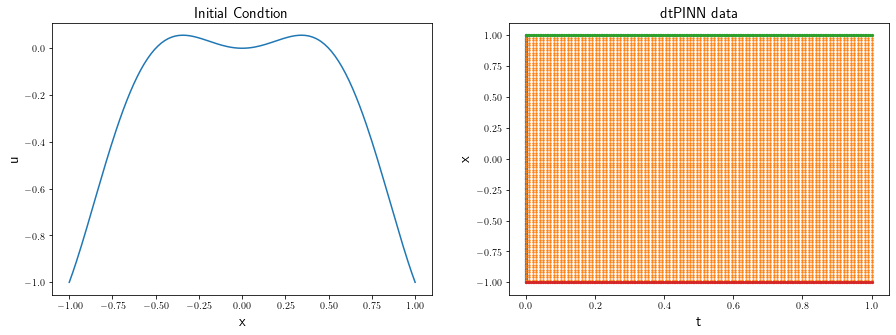

In [4]:
dataPar = generate_trainData(dataPar, userPar)
sample_plot(dataPar, userPar)

## Step 3: Train model and visualize

### Step 3.1: Define training and visualization parameters

In [5]:
### Training visualization parameters
userPar['animation'] = 1; # Boolean for showing/saving snapshots to make animation. If 0, it will just show/save the end of training
userPar['save_fig'] = 1; # Save training figures
userPar['model_name'] = 'allenCahn_causal_grid_bc-set=off_null-set=off' # Name of file to save training snapshots under
userPar['show_fig'] = 1; # Display training figures
userPar['verbose'] = 1 # Print out various training varibles at train time such as loss and iterations
userPar['log'] = 1; # Logs rel L2 error, runtime, loss over iterations, prediction, etc.
SEED = 0

### Step 3.2: Initalize the model

In [6]:
print('SEED:', SEED); torch.manual_seed(SEED); np.random.seed(SEED);
start_time = time.time()
model = dtPINN(dataPar, userPar)
print(time.time() - start_time)

SEED: 0
Mean tensor(0.0100)
Min tensor(0.)
0.07697439193725586


### Step 3.3: Train the model

dtPINN
Train Adam:
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
M

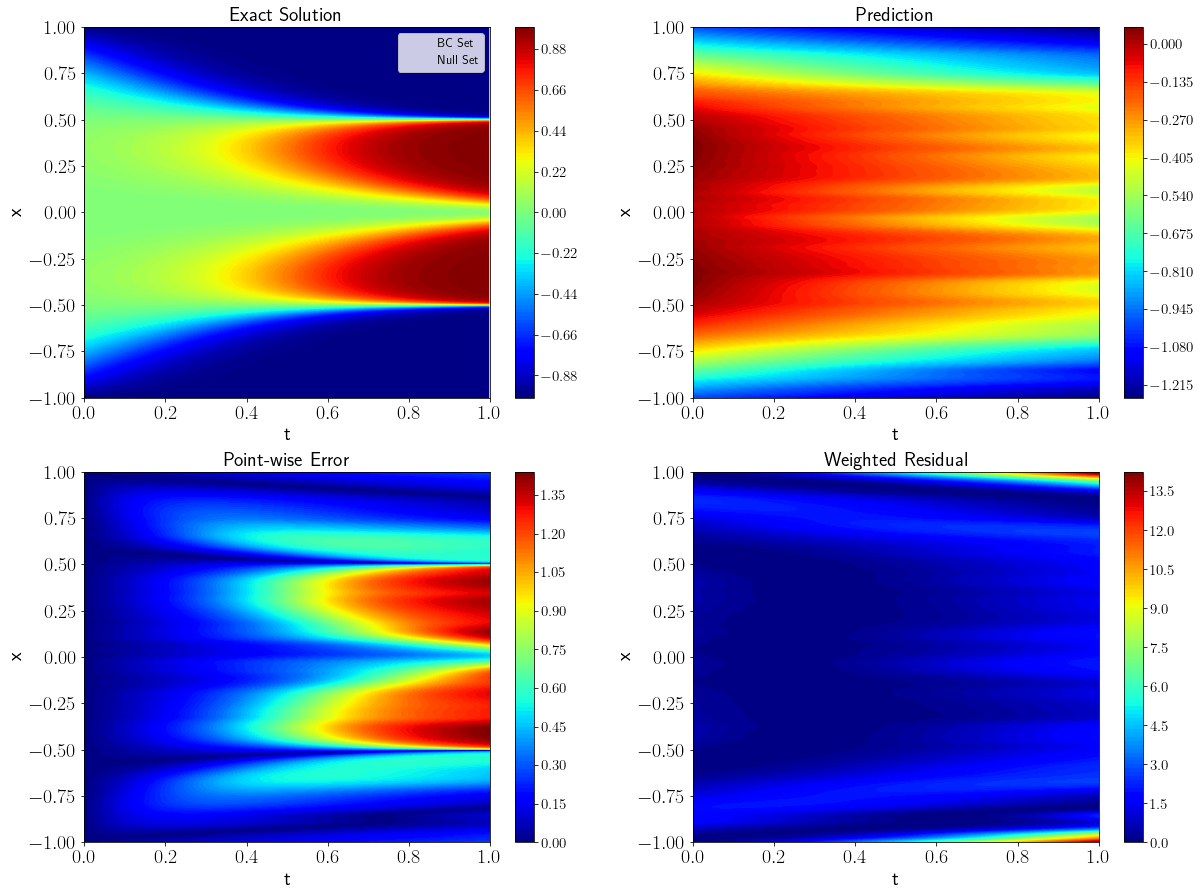

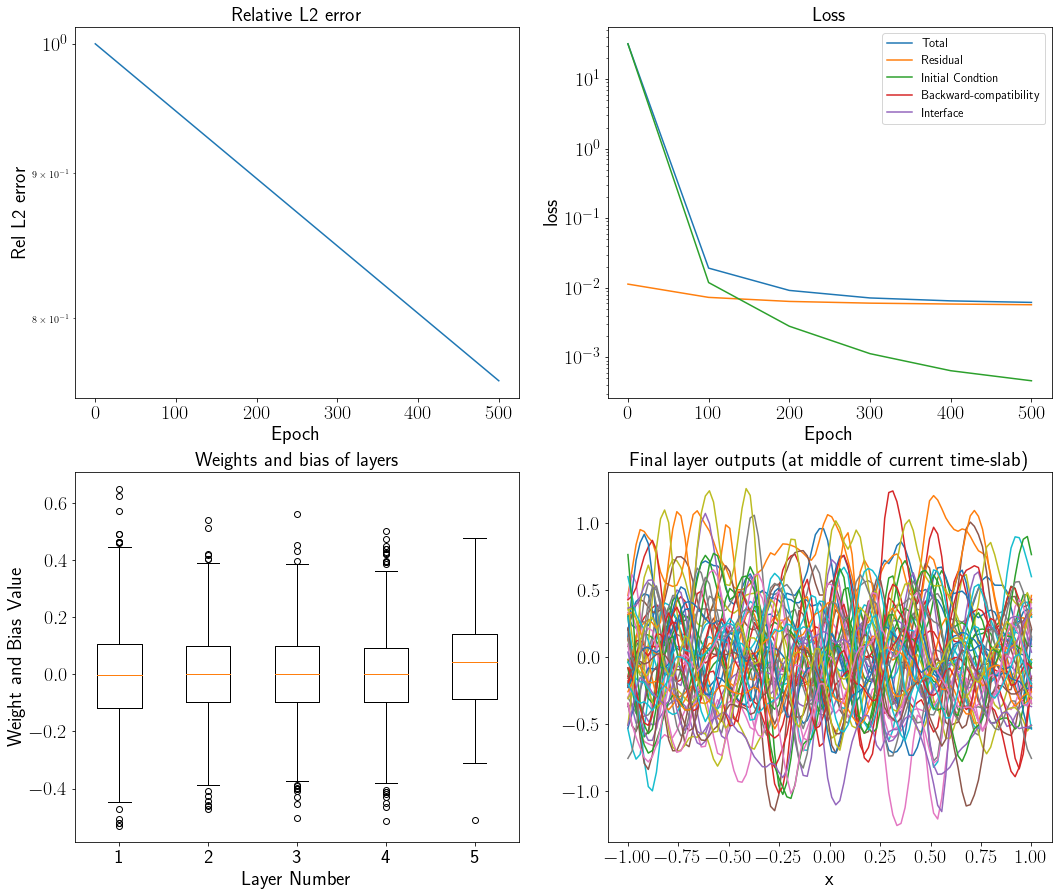

L2-error:  0.760394443014288
Train L-BFGS:
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(0.0100)
Min tensor(0.)
Mean tensor(

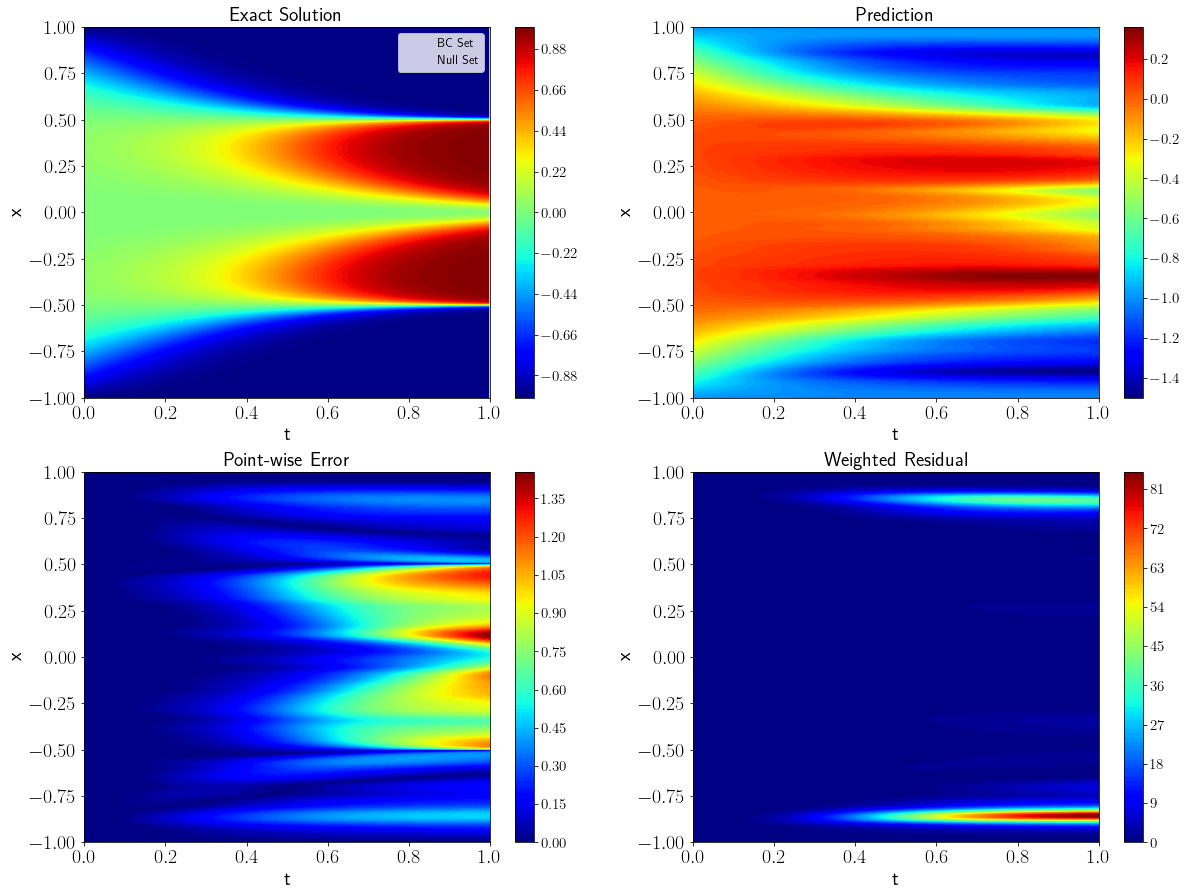

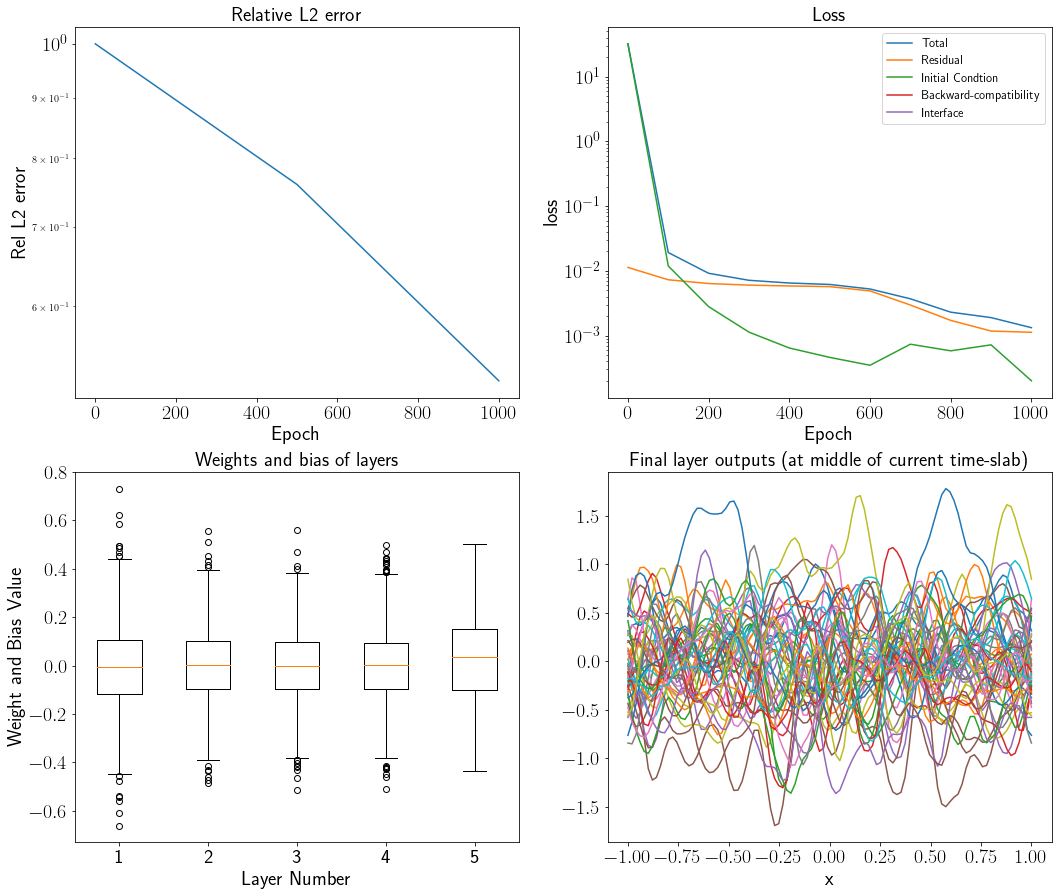

L2-error:  0.5188565390417339
Train L-BFGS:
Mean tensor(0.0696)
Min tensor(0.)
Mean tensor(0.0698)
Min tensor(0.)
Mean tensor(0.0700)
Min tensor(0.)
Mean tensor(0.0702)
Min tensor(0.)
Mean tensor(0.0704)
Min tensor(0.)
Mean tensor(0.0706)
Min tensor(0.)
Mean tensor(0.0708)
Min tensor(0.)
Mean tensor(0.0711)
Min tensor(0.)
Mean tensor(0.0714)
Min tensor(0.)
Mean tensor(0.0716)
Min tensor(0.)
Mean tensor(0.0720)
Min tensor(0.)
Mean tensor(0.0722)
Min tensor(0.)
Mean tensor(0.0725)
Min tensor(0.)
Mean tensor(0.0728)
Min tensor(0.)
Mean tensor(0.0730)
Min tensor(0.)
Mean tensor(0.0734)
Min tensor(0.)
Mean tensor(0.0737)
Min tensor(0.)
Mean tensor(0.0740)
Min tensor(0.)
Mean tensor(0.0744)
Min tensor(0.)
Mean tensor(0.0746)
Min tensor(0.)
Mean tensor(0.0750)
Min tensor(0.)
Mean tensor(0.0752)
Min tensor(0.)
Mean tensor(0.0755)
Min tensor(0.)
Mean tensor(0.0757)
Min tensor(0.)
Mean tensor(0.0759)
Min tensor(0.)
Mean tensor(0.0761)
Min tensor(0.)
Mean tensor(0.0763)
Min tensor(0.)
Mean tensor

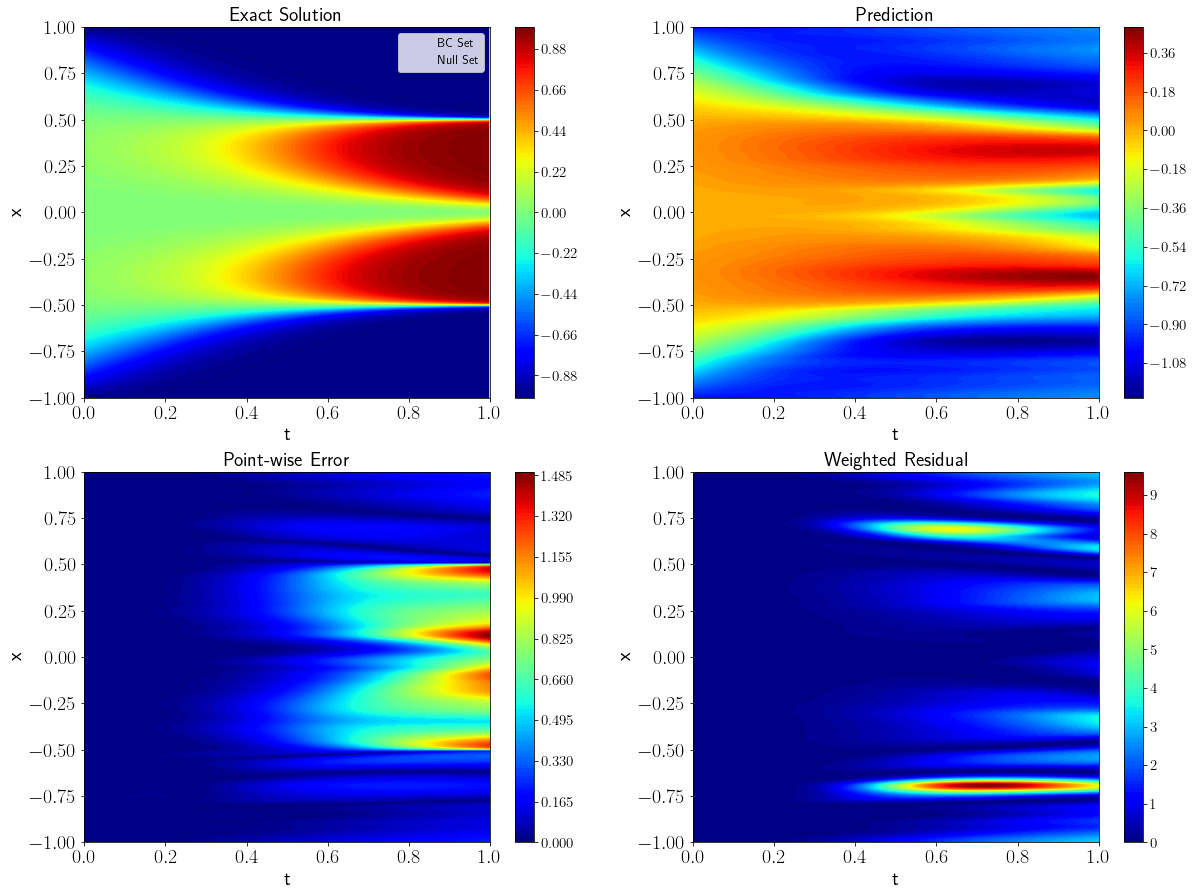

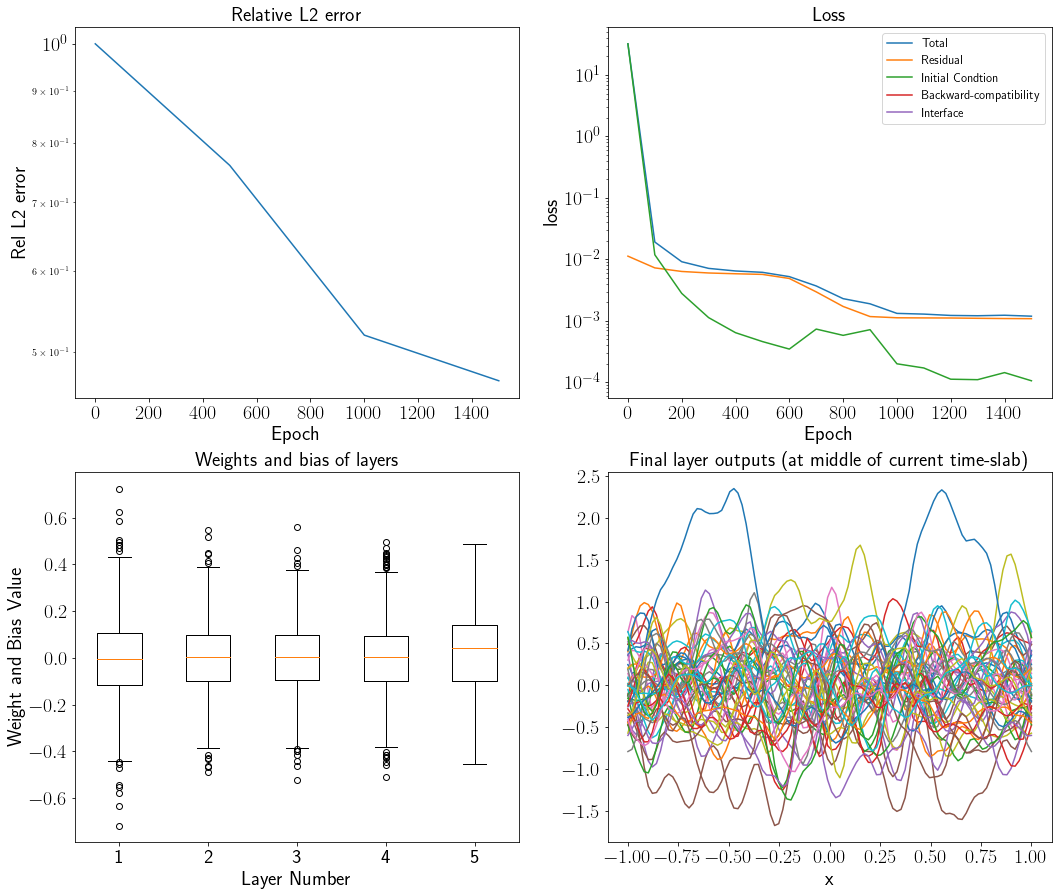

L2-error:  0.4681761879993103
Train L-BFGS:
Mean tensor(0.1579)
Min tensor(0.)
Mean tensor(0.1581)
Min tensor(0.)
Mean tensor(0.1584)
Min tensor(0.)
Mean tensor(0.1587)
Min tensor(0.)
Mean tensor(0.1590)
Min tensor(0.)
Mean tensor(0.1593)
Min tensor(0.)
Mean tensor(0.1595)
Min tensor(0.)
Mean tensor(0.1597)
Min tensor(0.)
Mean tensor(0.1600)
Min tensor(0.)
Mean tensor(0.1602)
Min tensor(0.)
Mean tensor(0.1604)
Min tensor(0.)
Mean tensor(0.1606)
Min tensor(0.)
Mean tensor(0.1607)
Min tensor(0.)
Mean tensor(0.1608)
Min tensor(0.)
Mean tensor(0.1609)
Min tensor(0.)
Mean tensor(0.1611)
Min tensor(0.)
Mean tensor(0.1612)
Min tensor(0.)
Mean tensor(0.1613)
Min tensor(0.)
Mean tensor(0.1614)
Min tensor(0.)
Mean tensor(0.1615)
Min tensor(0.)
Mean tensor(0.1617)
Min tensor(0.)
Mean tensor(0.1618)
Min tensor(0.)
Mean tensor(0.1620)
Min tensor(0.)
Mean tensor(0.1622)
Min tensor(0.)
Mean tensor(0.1624)
Min tensor(0.)
Mean tensor(0.1626)
Min tensor(0.)
Mean tensor(0.1628)
Min tensor(0.)
Mean tensor

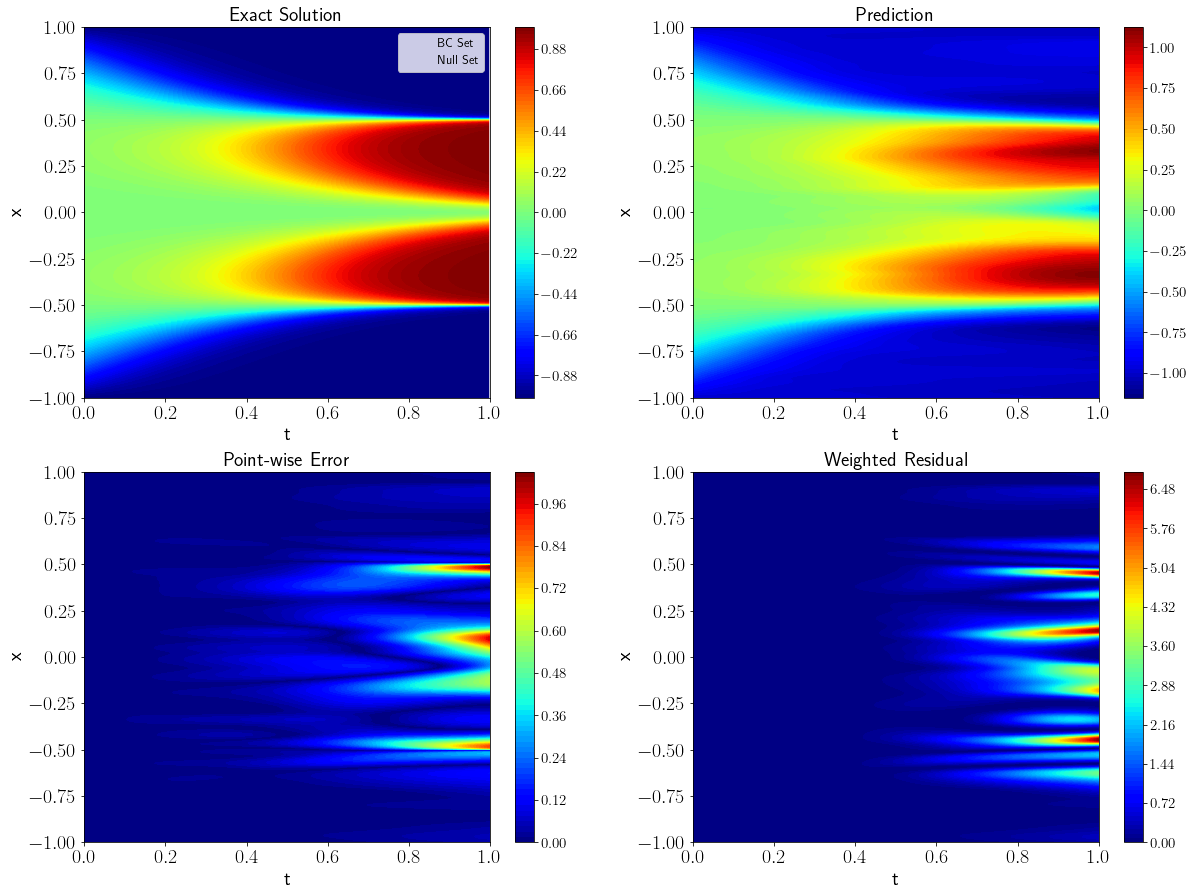

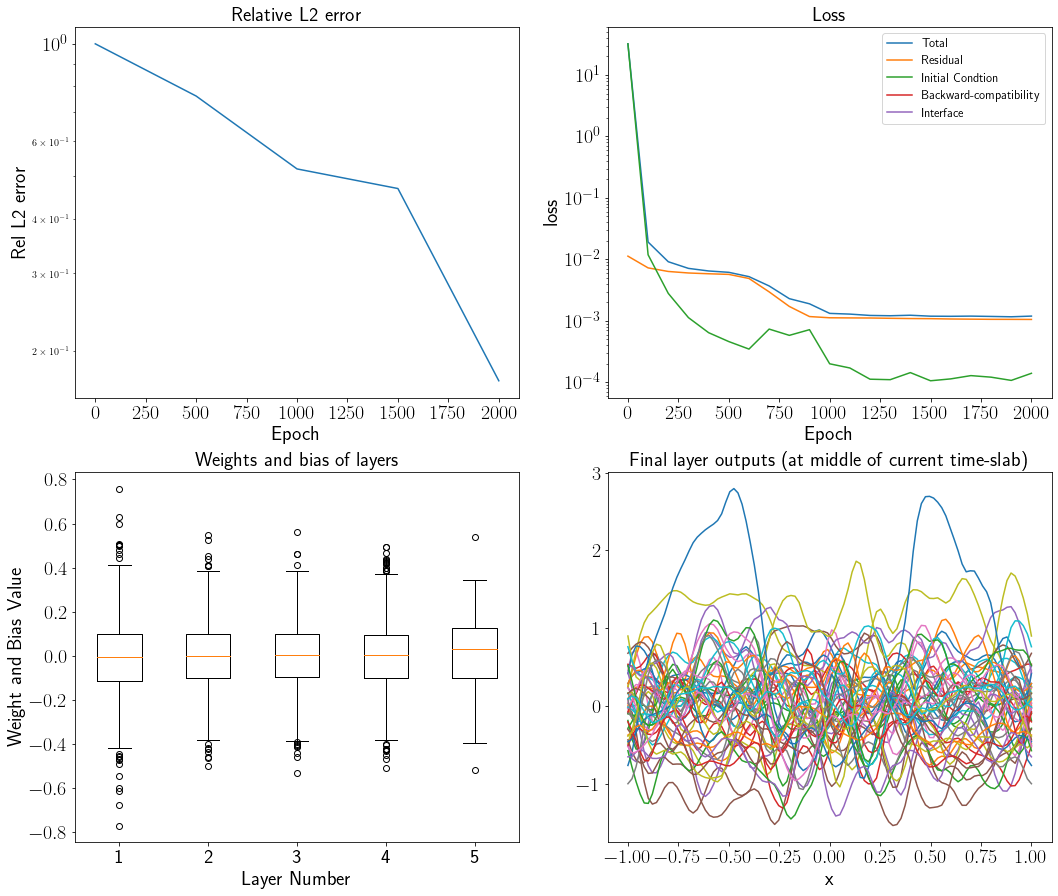

L2-error:  0.17082136626409317
Train L-BFGS:
Mean tensor(0.2584)
Min tensor(0.)
Mean tensor(0.2586)
Min tensor(0.)
Mean tensor(0.2586)
Min tensor(0.)
Mean tensor(0.2588)
Min tensor(0.)
Mean tensor(0.2588)
Min tensor(0.)
Mean tensor(0.2594)
Min tensor(0.)
Mean tensor(0.2595)
Min tensor(0.)
Mean tensor(0.2594)
Min tensor(0.)
Mean tensor(0.2597)
Min tensor(0.)
Mean tensor(0.2597)
Min tensor(0.)
Mean tensor(0.2598)
Min tensor(0.)
Mean tensor(0.2598)
Min tensor(0.)
Mean tensor(0.2600)
Min tensor(0.)
Mean tensor(0.2601)
Min tensor(0.)
Mean tensor(0.2602)
Min tensor(0.)
Mean tensor(0.2603)
Min tensor(0.)
Mean tensor(0.2611)
Min tensor(0.)
Mean tensor(0.2611)
Min tensor(0.)
Mean tensor(0.2613)
Min tensor(0.)
Mean tensor(0.2613)
Min tensor(0.)
Mean tensor(0.2615)
Min tensor(0.)
Mean tensor(0.2617)
Min tensor(0.)
Mean tensor(0.2620)
Min tensor(0.)
Mean tensor(0.2621)
Min tensor(0.)
Mean tensor(0.2623)
Min tensor(0.)
Mean tensor(0.2630)
Min tensor(0.)
Mean tensor(0.2634)
Min tensor(0.)
Mean tenso

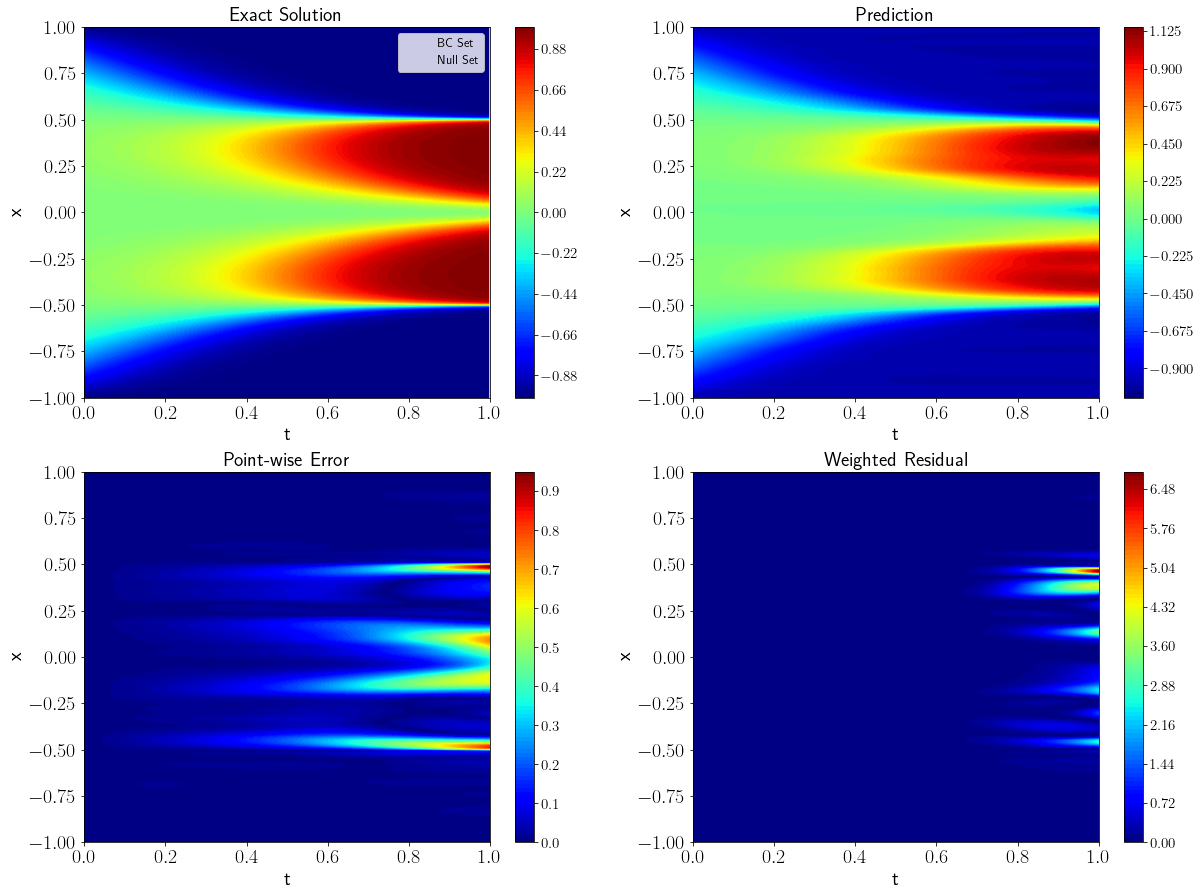

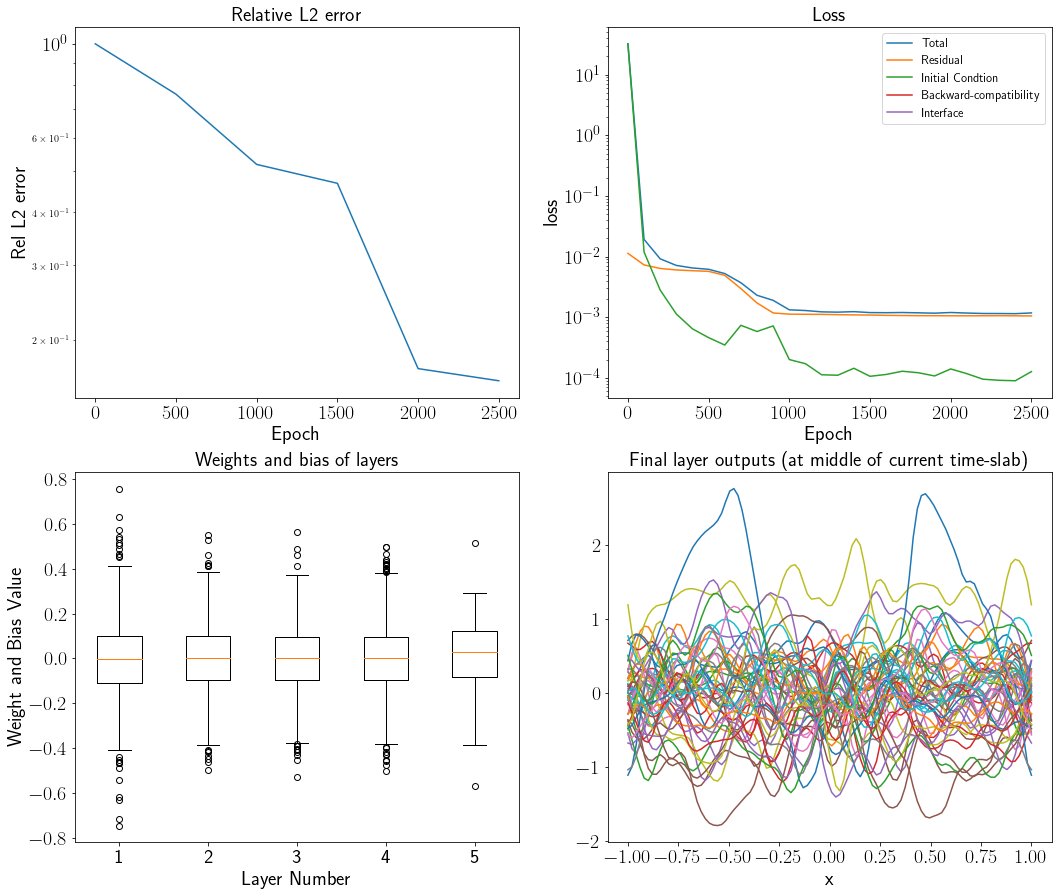

L2-error:  0.1598946306687382
Train L-BFGS:
Mean tensor(0.3695)
Min tensor(2.3880e-29)
Mean tensor(0.3692)
Min tensor(5.5950e-29)
Mean tensor(0.3681)
Min tensor(1.4253e-28)
Mean tensor(0.3678)
Min tensor(3.0666e-28)
Mean tensor(0.3678)
Min tensor(8.4538e-28)
Mean tensor(0.3674)
Min tensor(1.6708e-27)
Mean tensor(0.3674)
Min tensor(3.2948e-27)
Mean tensor(0.3670)
Min tensor(6.6854e-27)
Mean tensor(0.3669)
Min tensor(1.3227e-26)
Mean tensor(0.3671)
Min tensor(1.9744e-26)
Mean tensor(0.3667)
Min tensor(4.3398e-26)
Mean tensor(0.3667)
Min tensor(6.5185e-26)
Mean tensor(0.3666)
Min tensor(9.5481e-26)
Mean tensor(0.3666)
Min tensor(1.3052e-25)
Mean tensor(0.3667)
Min tensor(1.6919e-25)
Mean tensor(0.3668)
Min tensor(2.2289e-25)
Mean tensor(0.3670)
Min tensor(2.8001e-25)
Mean tensor(0.3672)
Min tensor(3.6284e-25)
Mean tensor(0.3675)
Min tensor(4.5736e-25)
Mean tensor(0.3676)
Min tensor(5.6665e-25)
Mean tensor(0.3683)
Min tensor(7.1848e-25)
Mean tensor(0.3684)
Min tensor(8.3526e-25)
Mean tenso

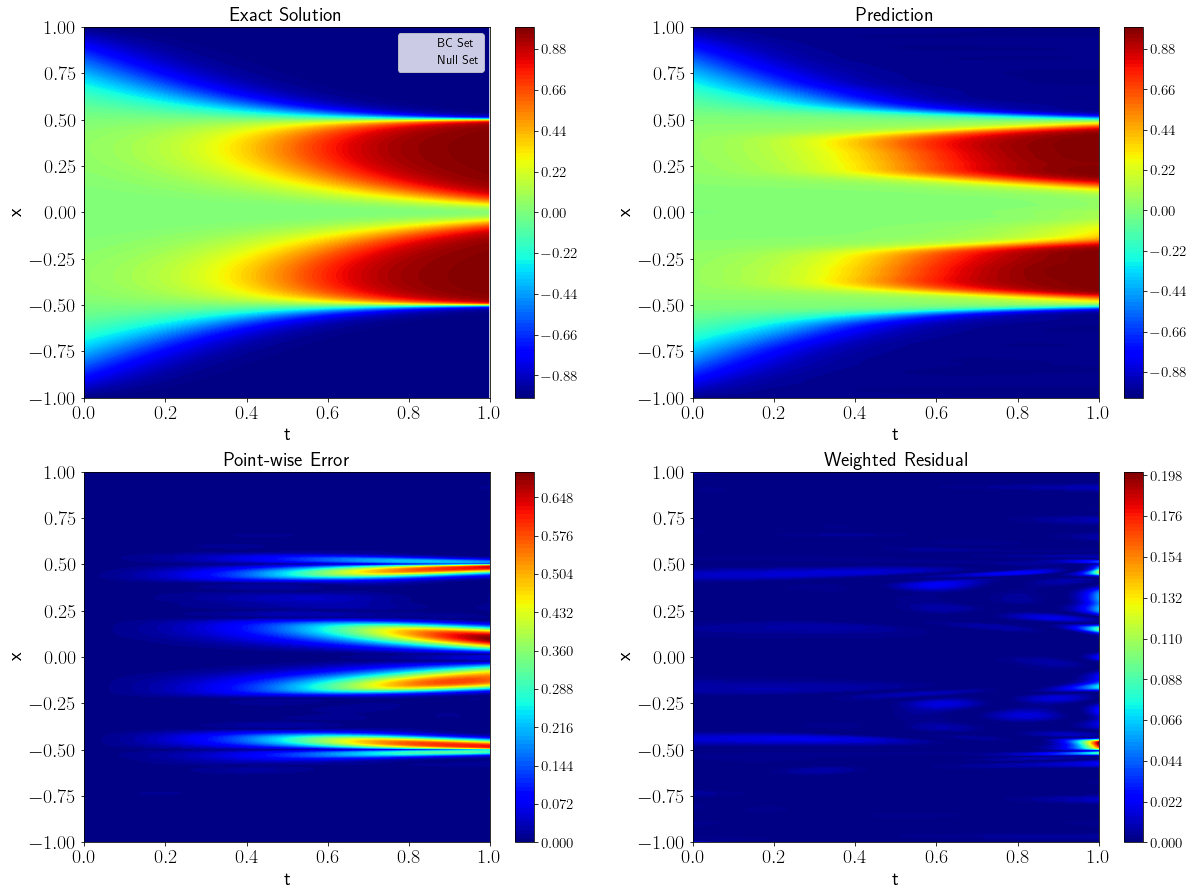

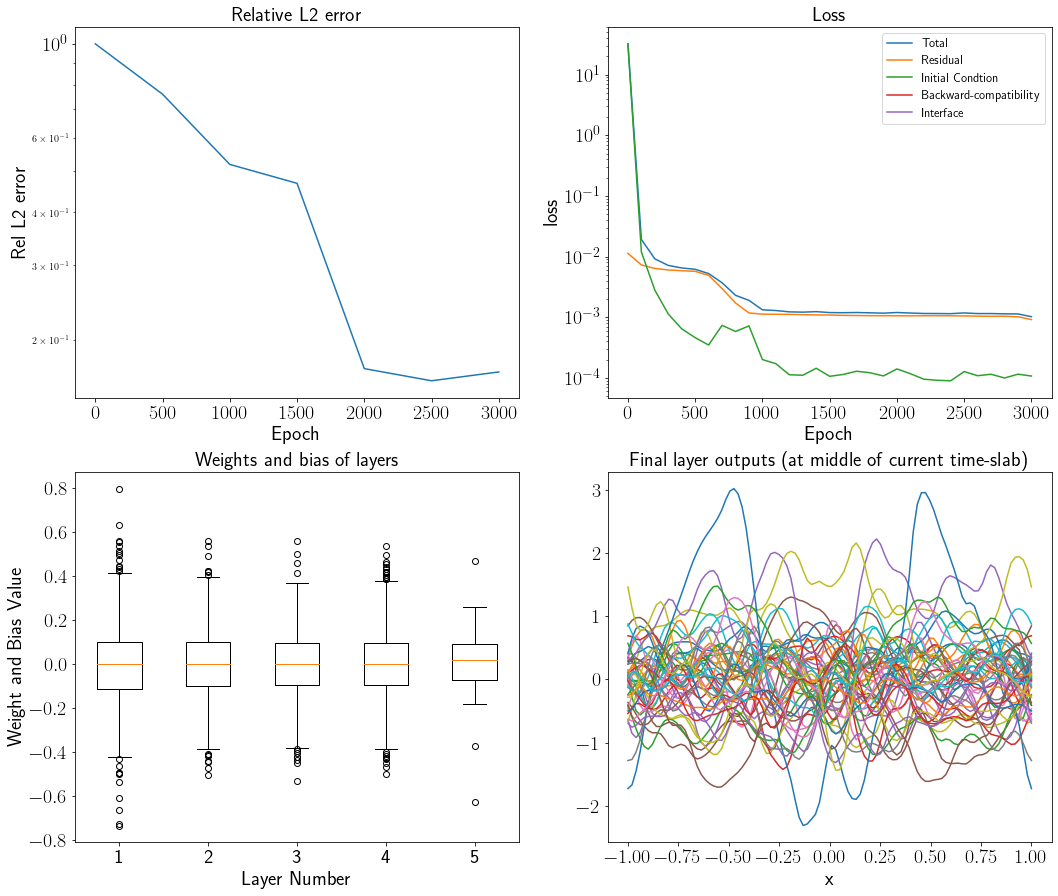

L2-error:  0.1677562412446905
Train L-BFGS:
Mean tensor(0.4884)
Min tensor(0.1170)
Mean tensor(0.4889)
Min tensor(0.1181)
Mean tensor(0.4895)
Min tensor(0.1193)
Mean tensor(0.4900)
Min tensor(0.1210)
Mean tensor(0.4907)
Min tensor(0.1224)
Mean tensor(0.4911)
Min tensor(0.1237)
Mean tensor(0.4916)
Min tensor(0.1249)
Mean tensor(0.4920)
Min tensor(0.1261)
Mean tensor(0.4926)
Min tensor(0.1277)
Mean tensor(0.4930)
Min tensor(0.1288)
Mean tensor(0.4935)
Min tensor(0.1300)
Mean tensor(0.4936)
Min tensor(0.1311)
Mean tensor(0.4941)
Min tensor(0.1323)
Mean tensor(0.4942)
Min tensor(0.1333)
Mean tensor(0.4947)
Min tensor(0.1344)
Mean tensor(0.4948)
Min tensor(0.1354)
Mean tensor(0.4956)
Min tensor(0.1366)
Mean tensor(0.4958)
Min tensor(0.1375)
Mean tensor(0.4967)
Min tensor(0.1389)
Mean tensor(0.4970)
Min tensor(0.1396)
Mean tensor(0.4975)
Min tensor(0.1405)
Mean tensor(0.4978)
Min tensor(0.1415)
Mean tensor(0.4982)
Min tensor(0.1421)
Mean tensor(0.4986)
Min tensor(0.1431)
Mean tensor(0.4989)


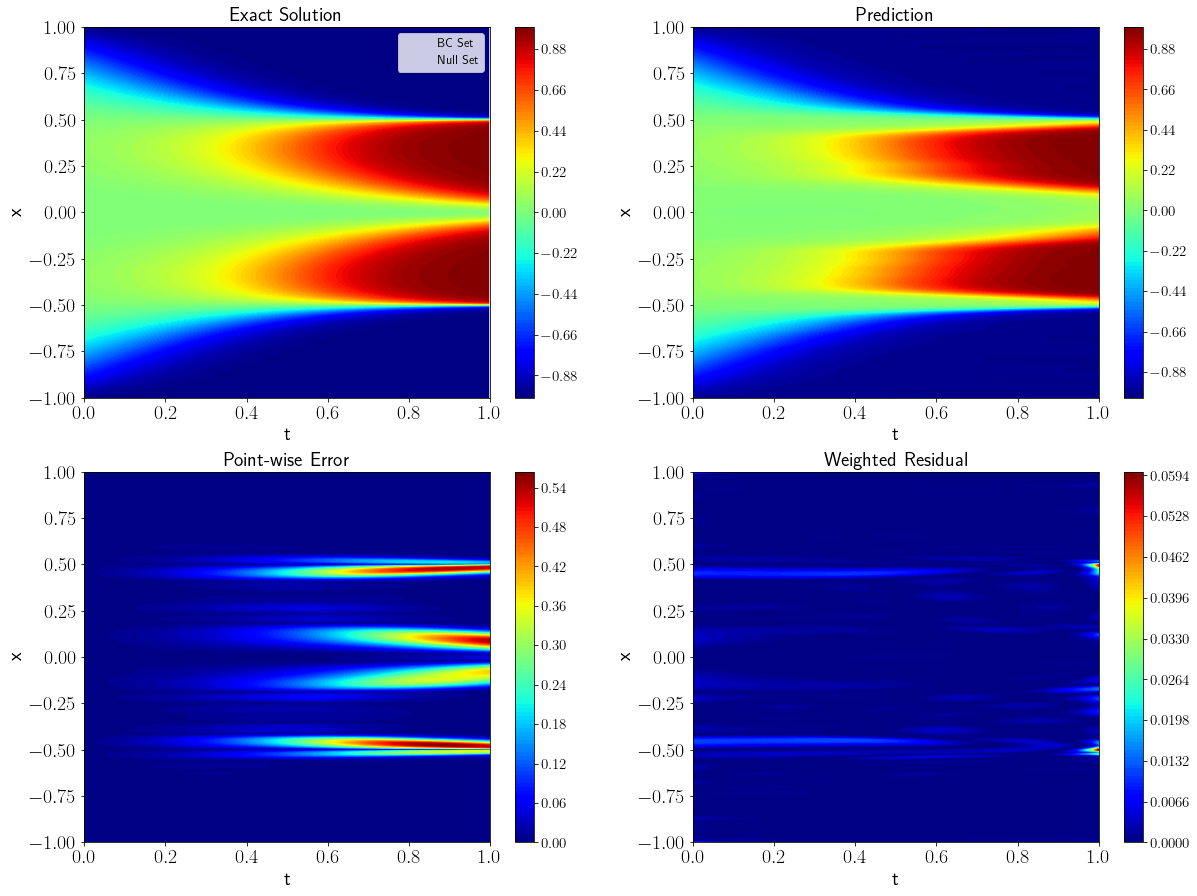

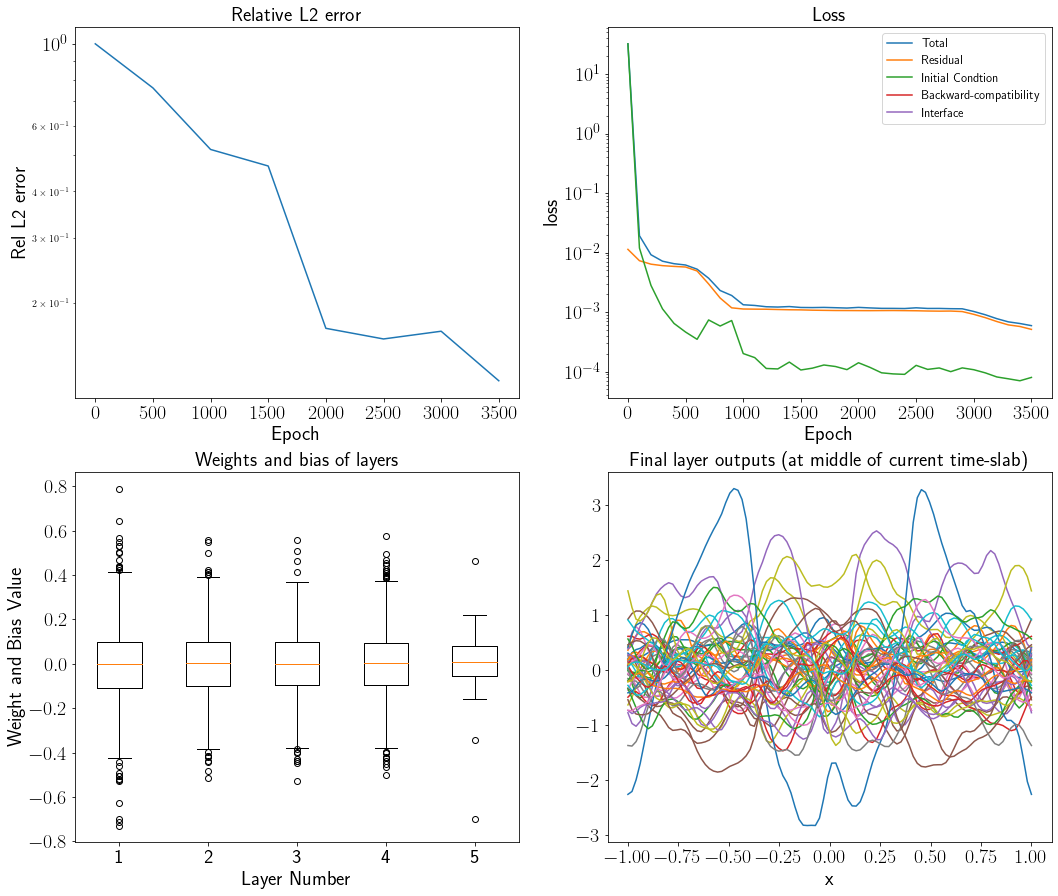

L2-error:  0.12332873011851486
Train L-BFGS:
Mean tensor(0.6963)
Min tensor(0.5080)
Mean tensor(0.6966)
Min tensor(0.5084)
Mean tensor(0.6968)
Min tensor(0.5088)
Mean tensor(0.6972)
Min tensor(0.5092)
Mean tensor(0.6976)
Min tensor(0.5099)
Mean tensor(0.6979)
Min tensor(0.5103)
Mean tensor(0.6984)
Min tensor(0.5110)
Mean tensor(0.6990)
Min tensor(0.5117)
Mean tensor(0.6994)
Min tensor(0.5124)
Mean tensor(0.7000)
Min tensor(0.5130)
Mean tensor(0.7004)
Min tensor(0.5136)
Mean tensor(0.7009)
Min tensor(0.5142)
Mean tensor(0.7014)
Min tensor(0.5147)
Mean tensor(0.7020)
Min tensor(0.5154)
Mean tensor(0.7023)
Min tensor(0.5159)
Mean tensor(0.7027)
Min tensor(0.5164)
Mean tensor(0.7030)
Min tensor(0.5168)
Mean tensor(0.7033)
Min tensor(0.5175)
Mean tensor(0.7036)
Min tensor(0.5179)
Mean tensor(0.7038)
Min tensor(0.5184)
Mean tensor(0.7039)
Min tensor(0.5187)
Mean tensor(0.7042)
Min tensor(0.5191)
Mean tensor(0.7043)
Min tensor(0.5194)
Mean tensor(0.7045)
Min tensor(0.5198)
Mean tensor(0.7045)

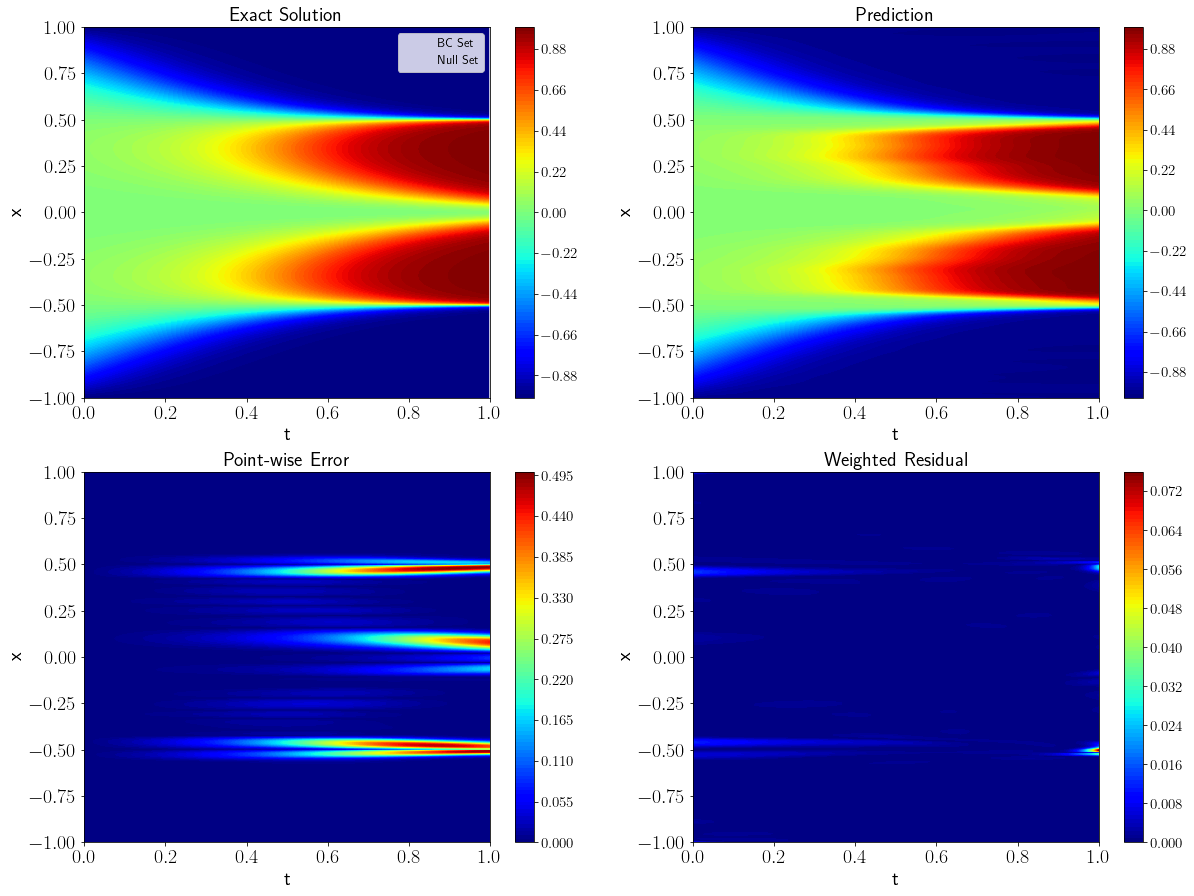

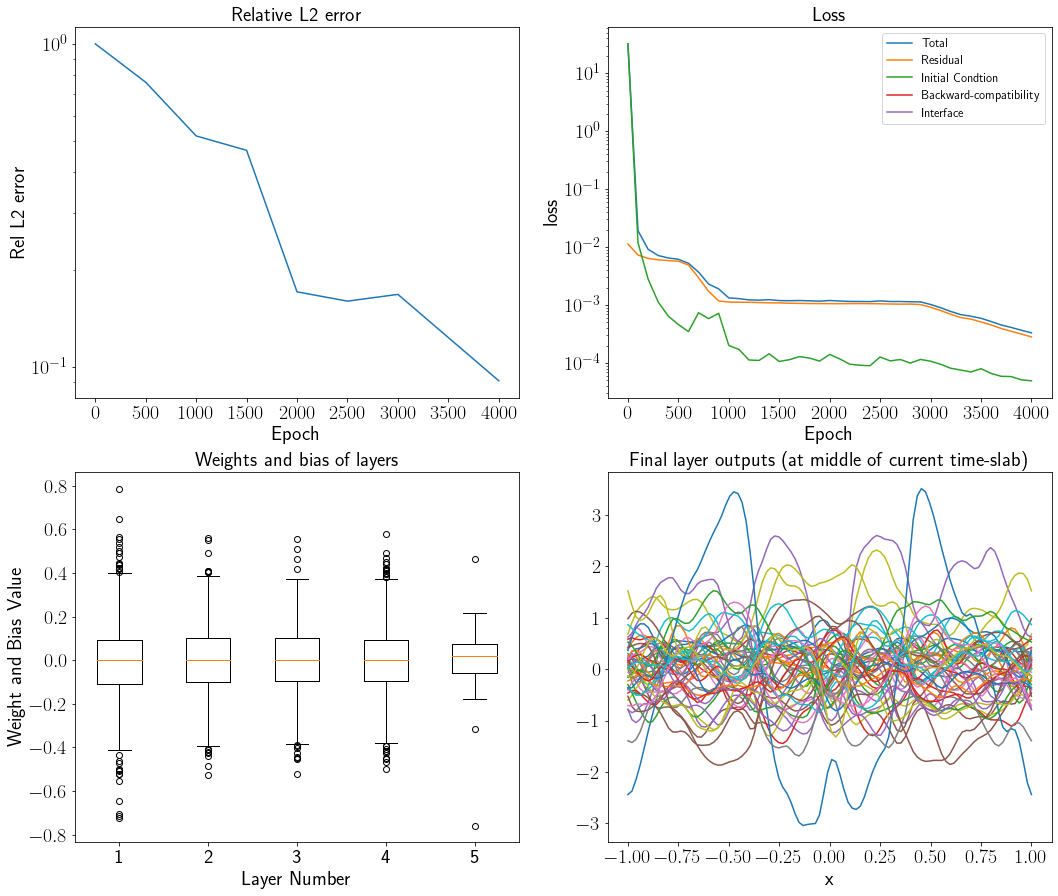

L2-error:  0.09065826813984304
Train L-BFGS:
Mean tensor(0.8260)
Min tensor(0.7302)
Mean tensor(0.8262)
Min tensor(0.7306)
Mean tensor(0.8264)
Min tensor(0.7310)
Mean tensor(0.8266)
Min tensor(0.7314)
Mean tensor(0.8268)
Min tensor(0.7318)
Mean tensor(0.8269)
Min tensor(0.7321)
Mean tensor(0.8270)
Min tensor(0.7324)
Mean tensor(0.8272)
Min tensor(0.7326)
Mean tensor(0.8273)
Min tensor(0.7329)
Mean tensor(0.8275)
Min tensor(0.7331)
Mean tensor(0.8276)
Min tensor(0.7334)
Mean tensor(0.8277)
Min tensor(0.7336)
Mean tensor(0.8278)
Min tensor(0.7338)
Mean tensor(0.8279)
Min tensor(0.7339)
Mean tensor(0.8280)
Min tensor(0.7341)
Mean tensor(0.8280)
Min tensor(0.7342)
Mean tensor(0.8281)
Min tensor(0.7343)
Mean tensor(0.8282)
Min tensor(0.7345)
Mean tensor(0.8283)
Min tensor(0.7347)
Mean tensor(0.8284)
Min tensor(0.7348)
Mean tensor(0.8285)
Min tensor(0.7350)
Mean tensor(0.8285)
Min tensor(0.7352)
Mean tensor(0.8288)
Min tensor(0.7356)
Mean tensor(0.8288)
Min tensor(0.7357)
Mean tensor(0.8289)

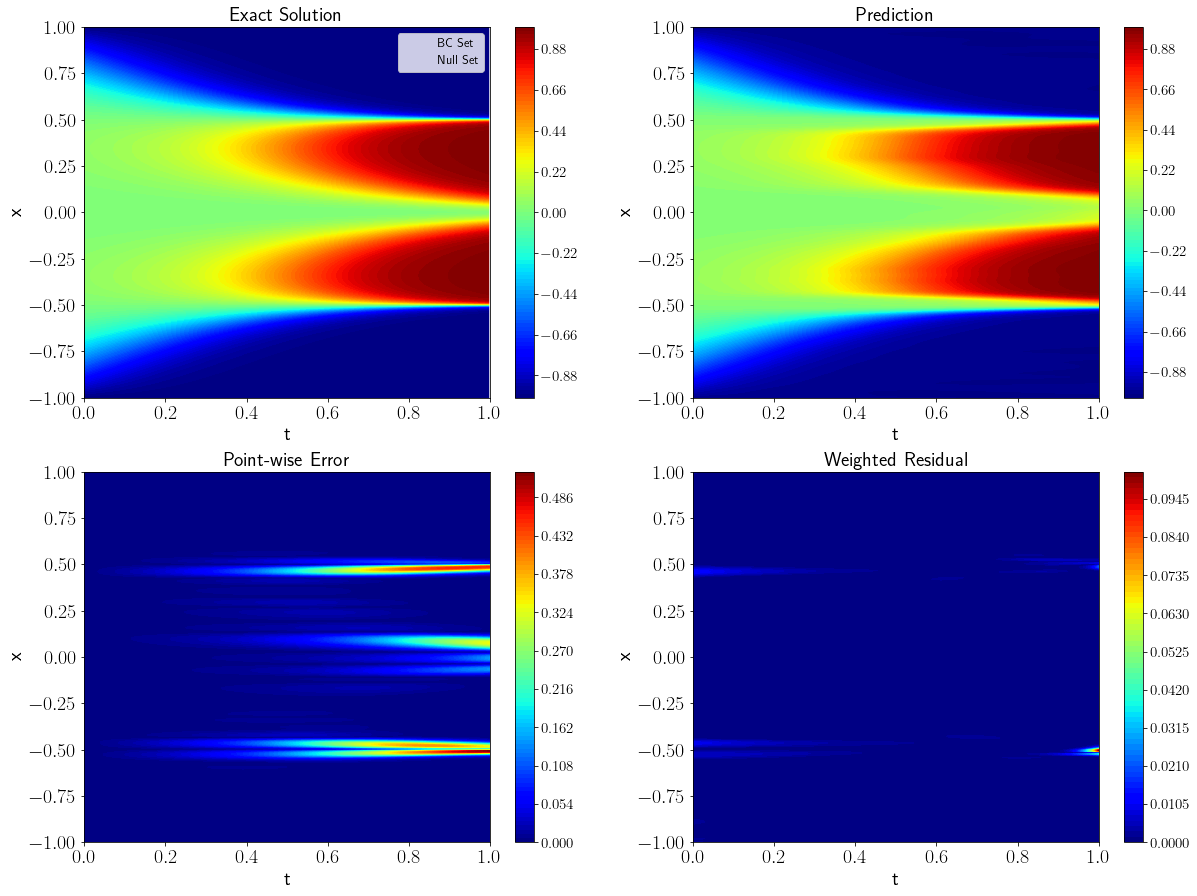

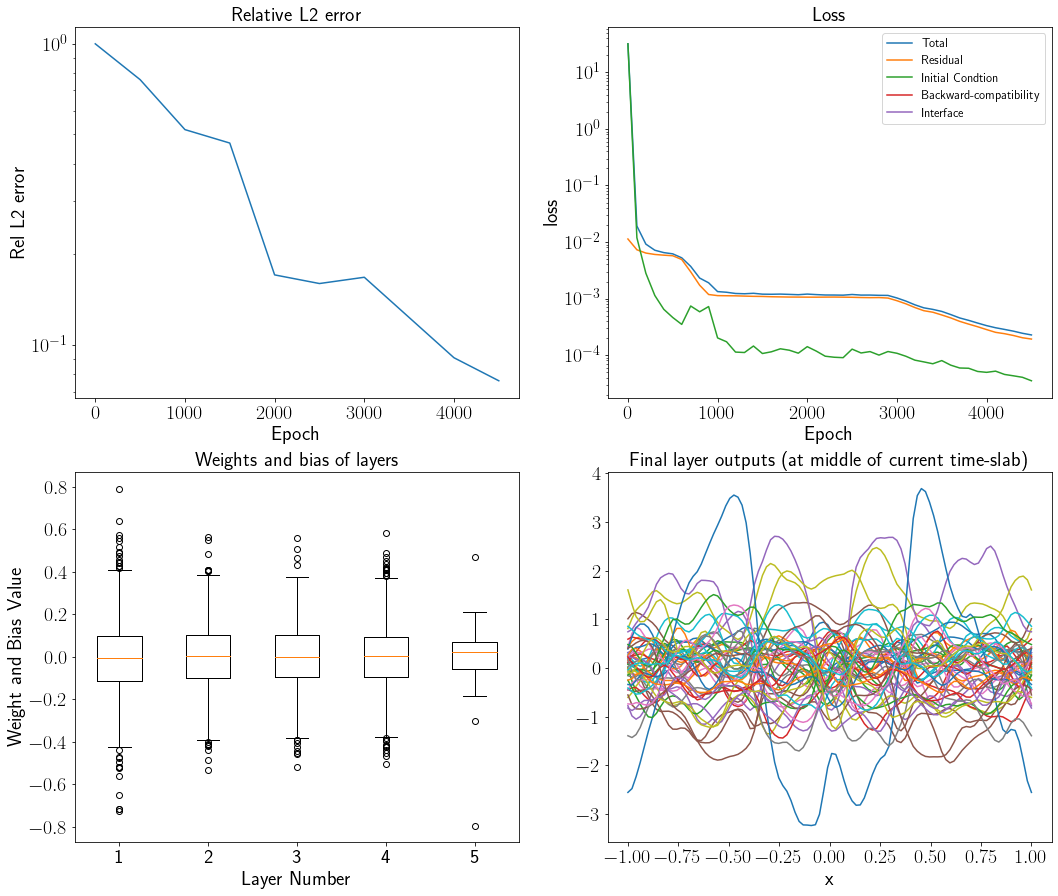

L2-error:  0.07601617075562393
Train L-BFGS:
Mean tensor(0.8782)
Min tensor(0.8165)
Mean tensor(0.8784)
Min tensor(0.8168)
Mean tensor(0.8786)
Min tensor(0.8171)
Mean tensor(0.8788)
Min tensor(0.8173)
Mean tensor(0.8790)
Min tensor(0.8176)
Mean tensor(0.8792)
Min tensor(0.8178)
Mean tensor(0.8795)
Min tensor(0.8182)
Mean tensor(0.8797)
Min tensor(0.8184)
Mean tensor(0.8799)
Min tensor(0.8187)
Mean tensor(0.8801)
Min tensor(0.8189)
Mean tensor(0.8803)
Min tensor(0.8192)
Mean tensor(0.8805)
Min tensor(0.8195)
Mean tensor(0.8807)
Min tensor(0.8197)
Mean tensor(0.8810)
Min tensor(0.8200)
Mean tensor(0.8812)
Min tensor(0.8203)
Mean tensor(0.8815)
Min tensor(0.8206)
Mean tensor(0.8817)
Min tensor(0.8208)
Mean tensor(0.8819)
Min tensor(0.8211)
Mean tensor(0.8821)
Min tensor(0.8213)
Mean tensor(0.8823)
Min tensor(0.8215)
Mean tensor(0.8824)
Min tensor(0.8217)
Mean tensor(0.8826)
Min tensor(0.8219)
Mean tensor(0.8828)
Min tensor(0.8221)
Mean tensor(0.8830)
Min tensor(0.8223)
Mean tensor(0.8832)

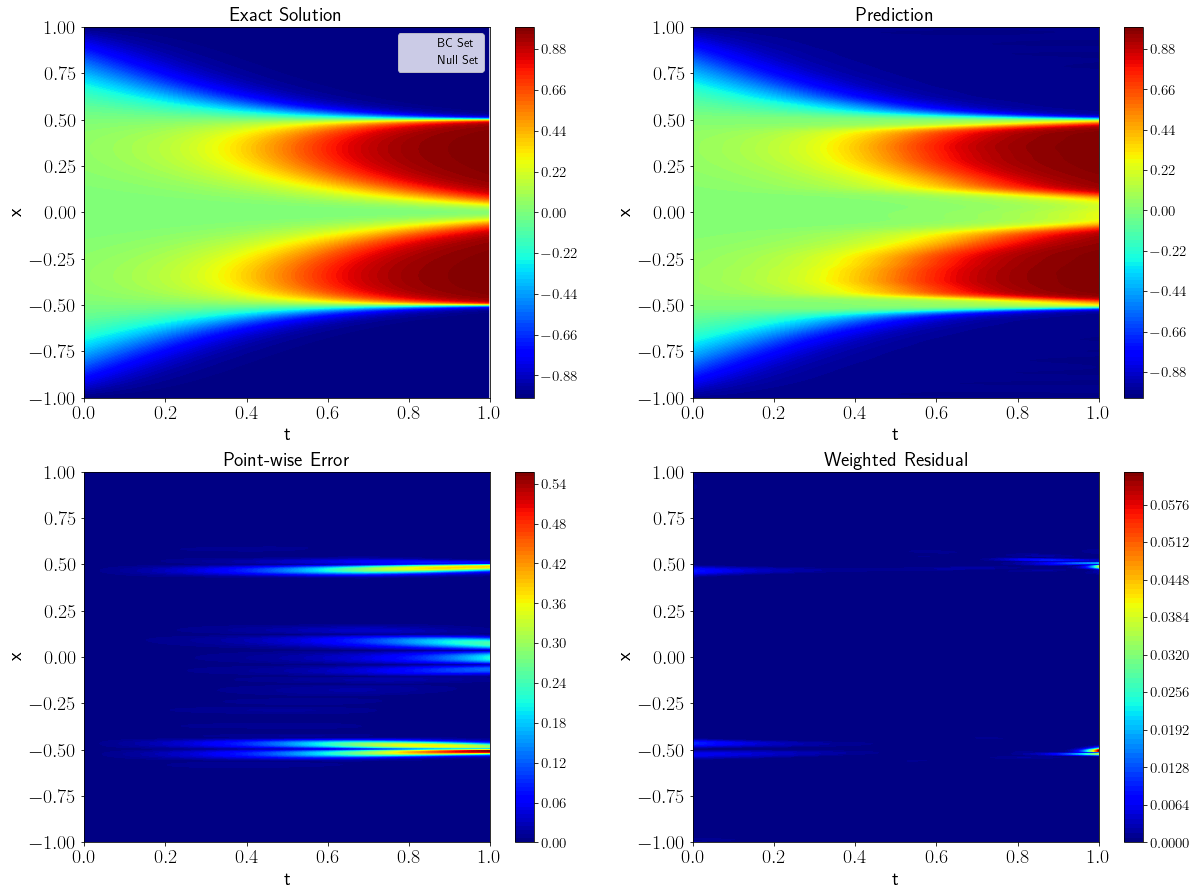

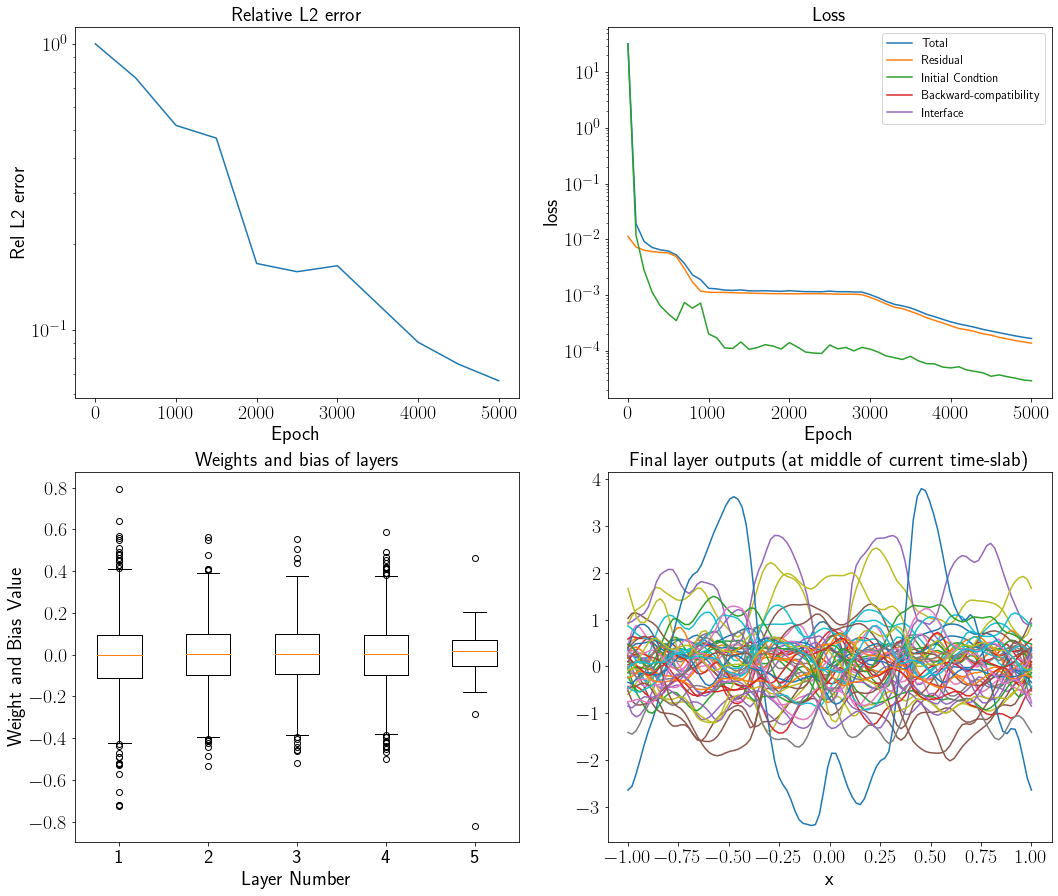

L2-error:  0.06650102707749375
Train L-BFGS:
Mean tensor(0.9103)
Min tensor(0.8682)
Mean tensor(0.9103)
Min tensor(0.8683)
Mean tensor(0.9104)
Min tensor(0.8684)
Mean tensor(0.9104)
Min tensor(0.8684)
Mean tensor(0.9105)
Min tensor(0.8685)
Mean tensor(0.9105)
Min tensor(0.8685)
Mean tensor(0.9106)
Min tensor(0.8686)
Mean tensor(0.9106)
Min tensor(0.8686)
Mean tensor(0.9106)
Min tensor(0.8687)
Mean tensor(0.9107)
Min tensor(0.8687)
Mean tensor(0.9107)
Min tensor(0.8687)
Mean tensor(0.9107)
Min tensor(0.8688)
Mean tensor(0.9107)
Min tensor(0.8688)
Mean tensor(0.9108)
Min tensor(0.8688)
Mean tensor(0.9108)
Min tensor(0.8688)
Mean tensor(0.9108)
Min tensor(0.8688)
Mean tensor(0.9108)
Min tensor(0.8689)
Mean tensor(0.9108)
Min tensor(0.8689)
Mean tensor(0.9108)
Min tensor(0.8689)
Mean tensor(0.9108)
Min tensor(0.8689)
Mean tensor(0.9109)
Min tensor(0.8690)
Mean tensor(0.9109)
Min tensor(0.8690)
Mean tensor(0.9109)
Min tensor(0.8690)
Mean tensor(0.9109)
Min tensor(0.8690)
Mean tensor(0.9109)

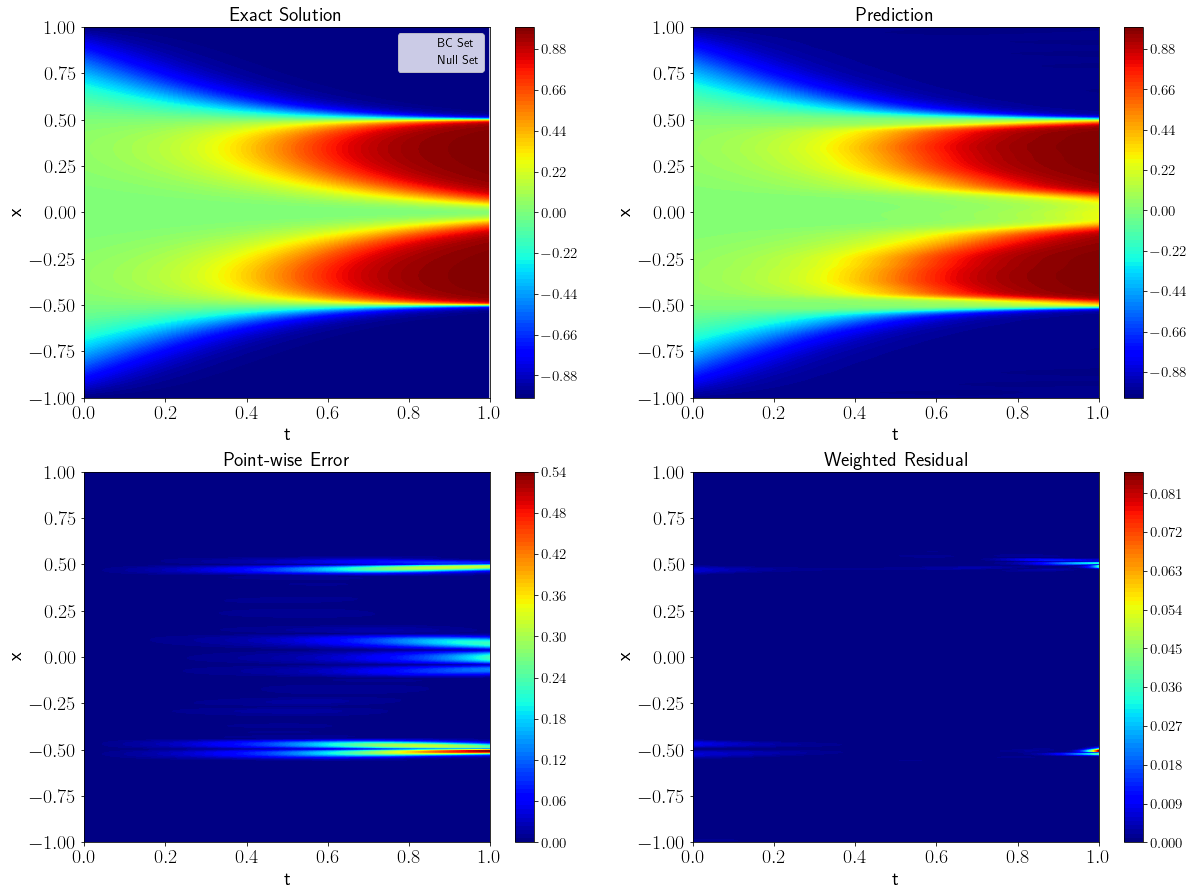

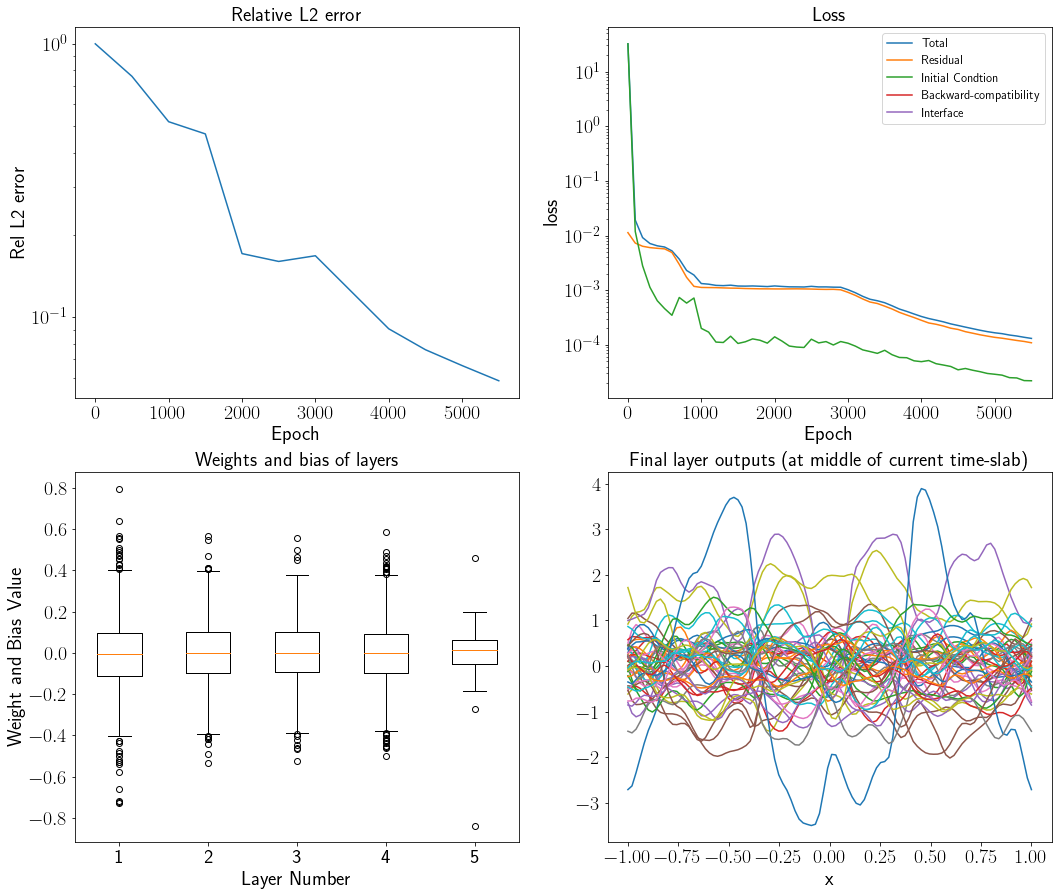

L2-error:  0.05851809827010648
Train L-BFGS:
Mean tensor(0.9316)
Min tensor(0.8957)
Mean tensor(0.9316)
Min tensor(0.8958)
Mean tensor(0.9316)
Min tensor(0.8958)
Mean tensor(0.9317)
Min tensor(0.8959)
Mean tensor(0.9317)
Min tensor(0.8959)
Mean tensor(0.9317)
Min tensor(0.8960)
Mean tensor(0.9318)
Min tensor(0.8960)
Mean tensor(0.9318)
Min tensor(0.8960)
Mean tensor(0.9318)
Min tensor(0.8961)
Mean tensor(0.9319)
Min tensor(0.8961)
Mean tensor(0.9319)
Min tensor(0.8961)
Mean tensor(0.9319)
Min tensor(0.8962)
Mean tensor(0.9319)
Min tensor(0.8962)
Mean tensor(0.9320)
Min tensor(0.8963)
Mean tensor(0.9320)
Min tensor(0.8963)
Mean tensor(0.9320)
Min tensor(0.8964)
Mean tensor(0.9320)
Min tensor(0.8964)
Mean tensor(0.9321)
Min tensor(0.8965)
Mean tensor(0.9321)
Min tensor(0.8965)
Mean tensor(0.9321)
Min tensor(0.8966)
Mean tensor(0.9321)
Min tensor(0.8966)
Mean tensor(0.9321)
Min tensor(0.8966)
Mean tensor(0.9321)
Min tensor(0.8966)
Mean tensor(0.9321)
Min tensor(0.8967)
Mean tensor(0.9320)

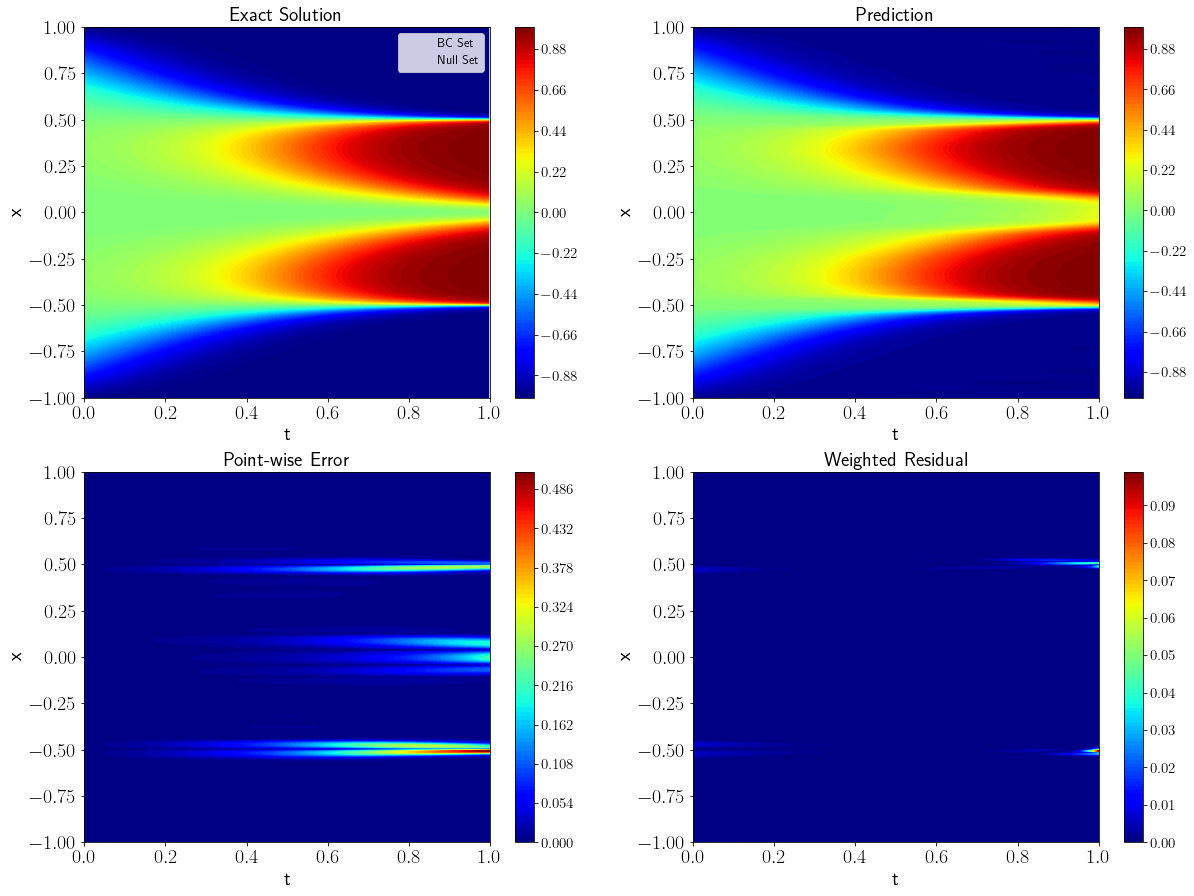

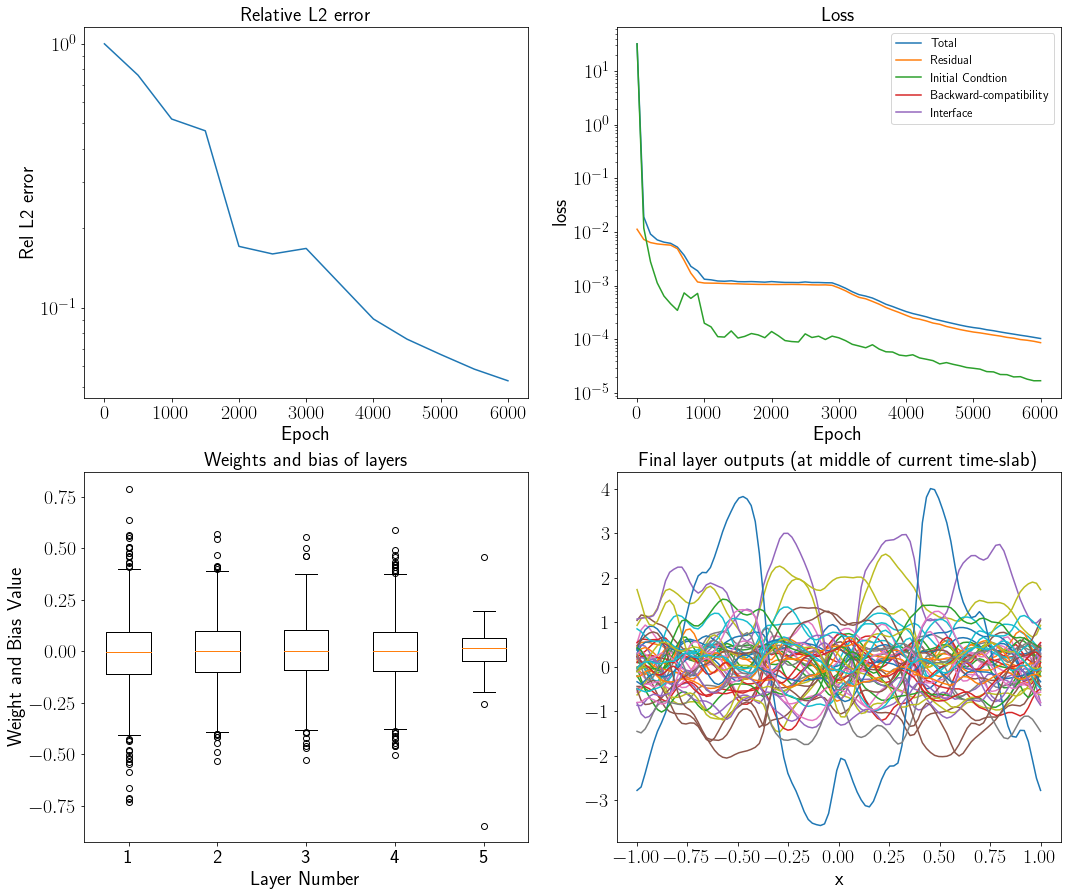

L2-error:  0.05287545673177556
Train L-BFGS:
Mean tensor(0.9457)
Min tensor(0.9170)
Mean tensor(0.9458)
Min tensor(0.9171)
Mean tensor(0.9459)
Min tensor(0.9172)
Mean tensor(0.9459)
Min tensor(0.9172)
Mean tensor(0.9460)
Min tensor(0.9173)
Mean tensor(0.9460)
Min tensor(0.9173)
Mean tensor(0.9461)
Min tensor(0.9173)
Mean tensor(0.9461)
Min tensor(0.9174)
Mean tensor(0.9461)
Min tensor(0.9174)
Mean tensor(0.9461)
Min tensor(0.9174)
Mean tensor(0.9462)
Min tensor(0.9175)
Mean tensor(0.9462)
Min tensor(0.9175)
Mean tensor(0.9462)
Min tensor(0.9175)
Mean tensor(0.9463)
Min tensor(0.9176)
Mean tensor(0.9463)
Min tensor(0.9176)
Mean tensor(0.9463)
Min tensor(0.9176)
Mean tensor(0.9463)
Min tensor(0.9176)
Mean tensor(0.9463)
Min tensor(0.9176)
Mean tensor(0.9463)
Min tensor(0.9176)
Mean tensor(0.9463)
Min tensor(0.9177)
Mean tensor(0.9463)
Min tensor(0.9177)
Mean tensor(0.9463)
Min tensor(0.9177)
Mean tensor(0.9463)
Min tensor(0.9177)
Mean tensor(0.9463)
Min tensor(0.9177)
Mean tensor(0.9463)

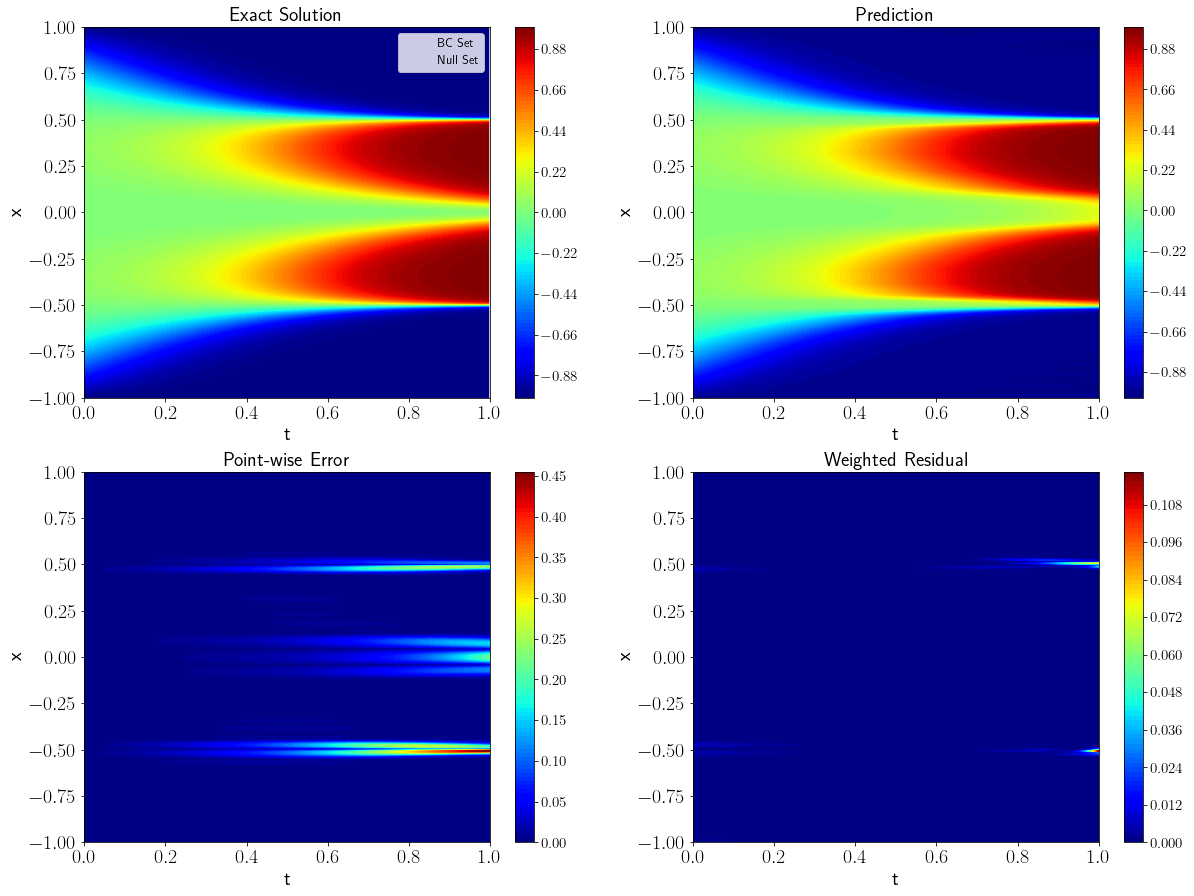

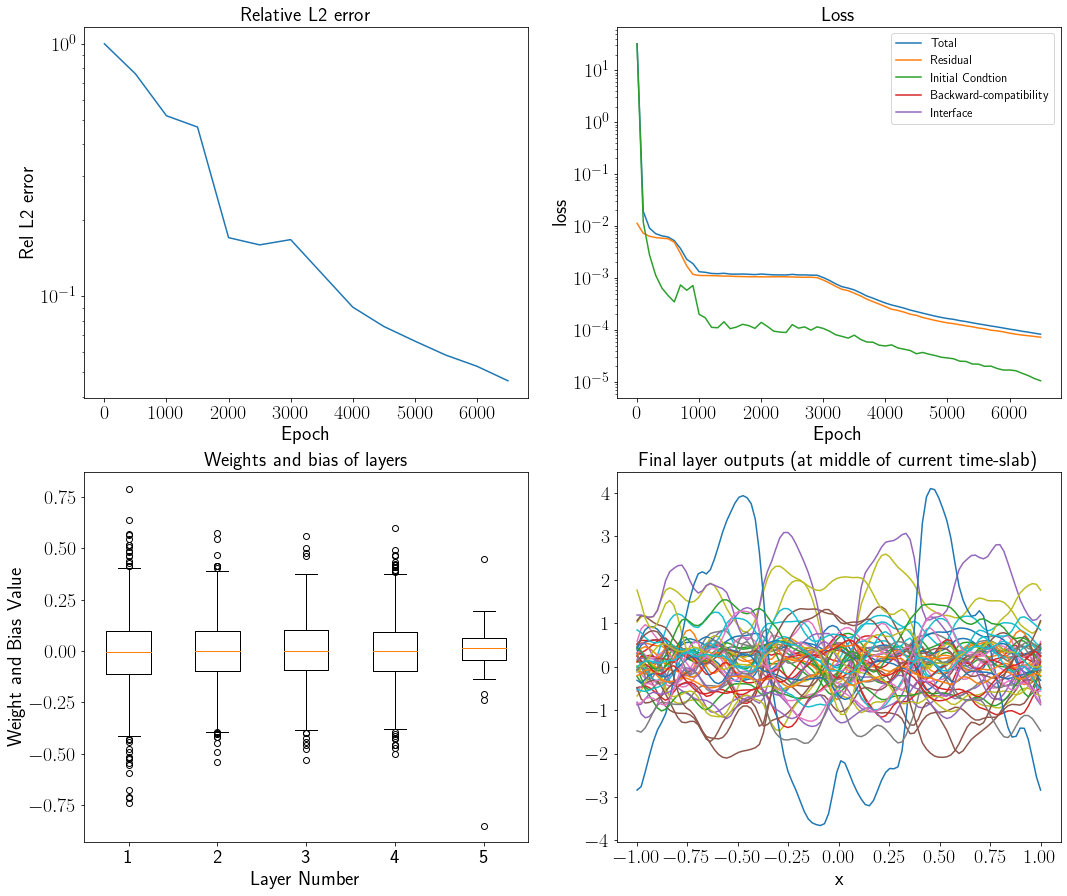

L2-error:  0.0463167397253652
Train L-BFGS:
Mean tensor(0.9561)
Min tensor(0.9312)
Mean tensor(0.9561)
Min tensor(0.9312)
Mean tensor(0.9561)
Min tensor(0.9312)
Mean tensor(0.9561)
Min tensor(0.9312)
Mean tensor(0.9561)
Min tensor(0.9313)
Mean tensor(0.9561)
Min tensor(0.9313)
Mean tensor(0.9561)
Min tensor(0.9313)
Mean tensor(0.9562)
Min tensor(0.9313)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9314)
Mean tensor(0.9562)
Min tensor(0.9315)
Mean tensor(0.9562)
Min tensor(0.9315)
Mean tensor(0.9562)
Min tensor(0.9315)
Mean tensor(0.9562)
Min tensor(0.9315)
Mean tensor(0.9562)
Min tensor(0.9315)
Mean tensor(0.9562)


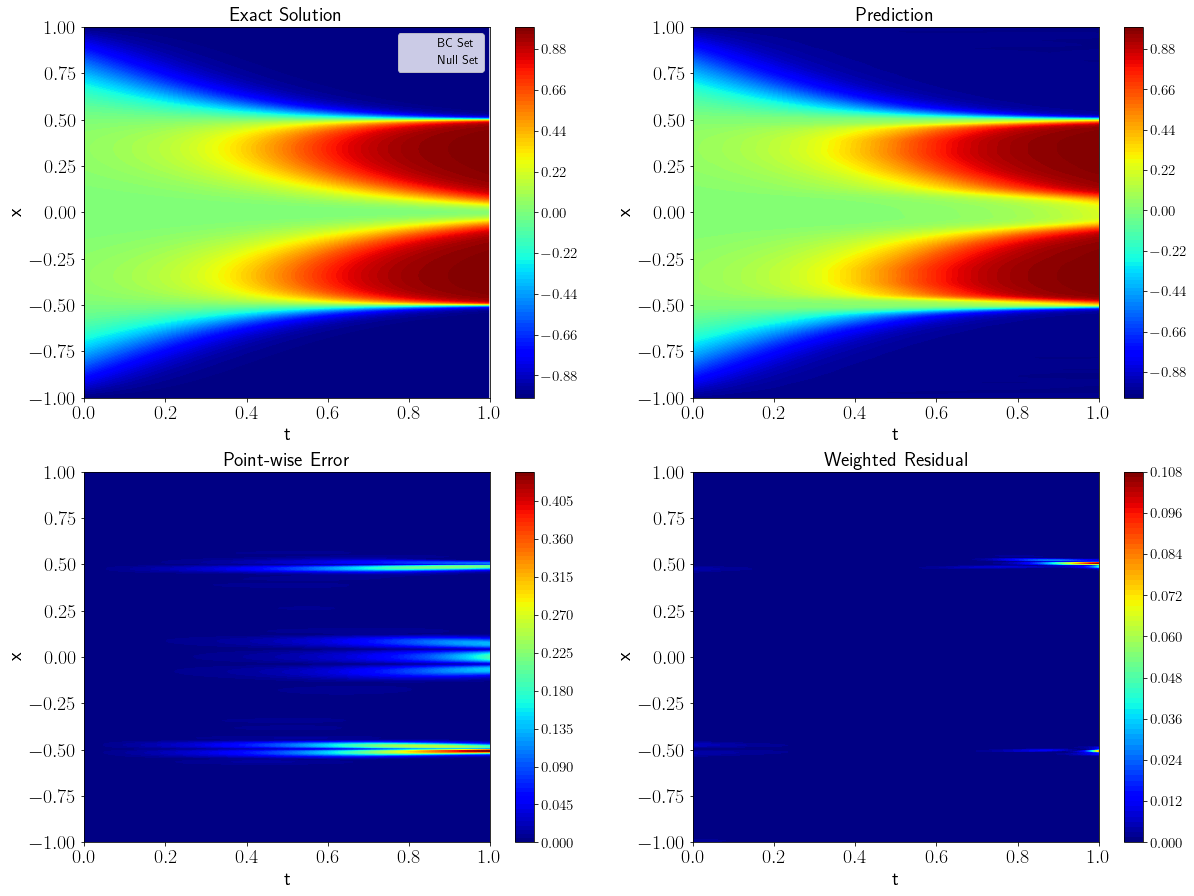

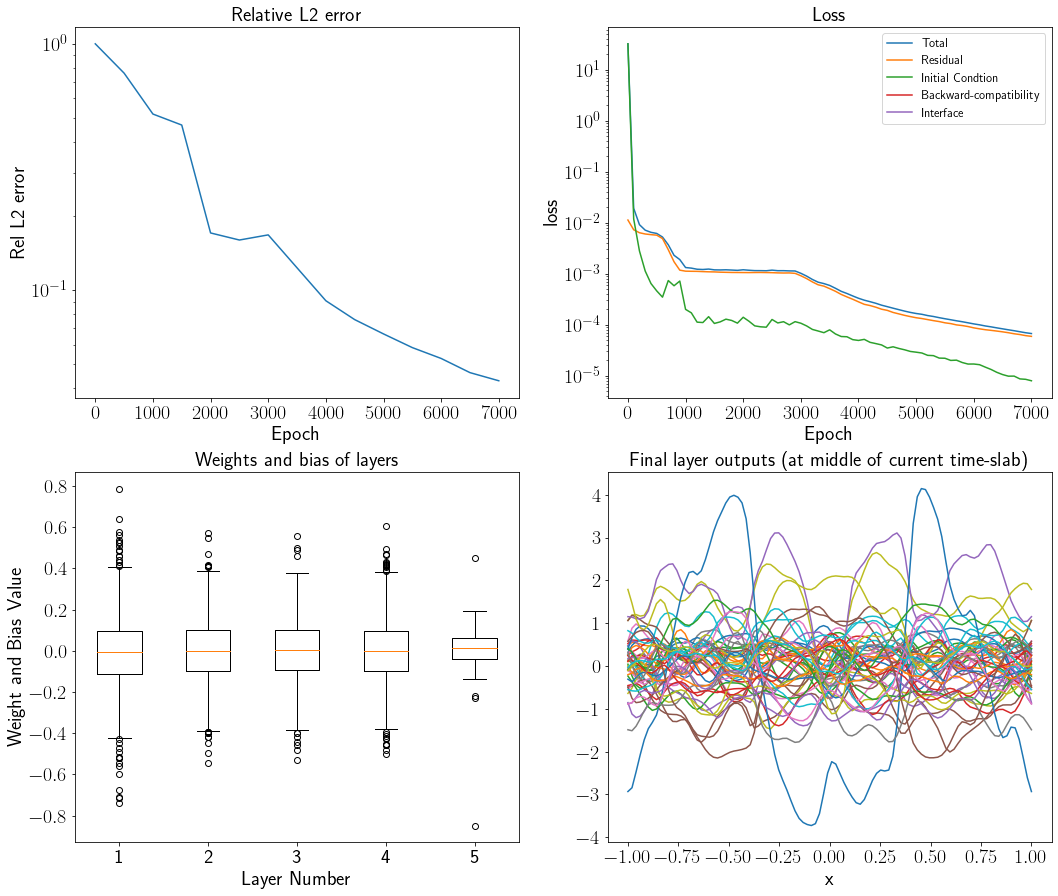

L2-error:  0.04292688434770318
Train L-BFGS:
Mean tensor(0.9621)
Min tensor(0.9433)
Mean tensor(0.9621)
Min tensor(0.9433)
Mean tensor(0.9621)
Min tensor(0.9434)
Mean tensor(0.9621)
Min tensor(0.9434)
Mean tensor(0.9621)
Min tensor(0.9434)
Mean tensor(0.9621)
Min tensor(0.9434)
Mean tensor(0.9621)
Min tensor(0.9434)
Mean tensor(0.9622)
Min tensor(0.9434)
Mean tensor(0.9622)
Min tensor(0.9435)
Mean tensor(0.9622)
Min tensor(0.9435)
Mean tensor(0.9622)
Min tensor(0.9435)
Mean tensor(0.9622)
Min tensor(0.9436)
Mean tensor(0.9622)
Min tensor(0.9436)
Mean tensor(0.9623)
Min tensor(0.9436)
Mean tensor(0.9623)
Min tensor(0.9437)
Mean tensor(0.9623)
Min tensor(0.9437)
Mean tensor(0.9624)
Min tensor(0.9438)
Mean tensor(0.9624)
Min tensor(0.9438)
Mean tensor(0.9624)
Min tensor(0.9439)
Mean tensor(0.9624)
Min tensor(0.9439)
Mean tensor(0.9625)
Min tensor(0.9439)
Mean tensor(0.9625)
Min tensor(0.9440)
Mean tensor(0.9625)
Min tensor(0.9440)
Mean tensor(0.9625)
Min tensor(0.9440)
Mean tensor(0.9626)

In [ ]:
adam_loops = 1
lbfgs_loops = 300
model = training_loop(userPar, dataPar, model, adam_loops, lbfgs_loops)